
### Path setup (root results)
Ensures we resolve the repo root and use the root `results/` directory (with legacy fallback under `src/.../results`).


In [18]:

from pathlib import Path
import sys
import pandas as pd

# Locate repo root (assumes running somewhere inside the repo)
cwd = Path.cwd().resolve()
REPO_ROOT = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "src" / "motion_planning").exists():
        REPO_ROOT = parent
        break

# Ensure src on path
src_path = REPO_ROOT / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("Repo root:", REPO_ROOT)
print("sys.path[0]:", sys.path[0])


Repo root: /home/abdulrahman/competitive-online-algorithms-motion-planning
sys.path[0]: /home/abdulrahman/competitive-online-algorithms-motion-planning/src


In [19]:

# Candidate locations to search (new root results + legacy src path)
SEARCH_BASES = [
    REPO_ROOT / "results",
    REPO_ROOT / "src/motion_planning/offline_problems/results",
]

def find_files(pattern: str):
    hits = []
    for base in SEARCH_BASES:
        if base.exists():
            hits.extend(base.rglob(pattern))
    return sorted(set(hits))

cand_files = find_files("*_candidates.csv")
edge_files = find_files("*_edge_values.csv")
timeline_files = find_files("*_decision_timeline.csv")
opt_solution_files = find_files("*_solution_edges.csv") + find_files("*_opt_solution.csv")

print("Found candidates:", cand_files[-2:])
print("Found edges:", edge_files[-2:])
print("Found timelines:", timeline_files[-2:])
print("Found offline solutions:", opt_solution_files[-2:])

sample_cand = cand_files[-1] if cand_files else None
sample_edge = edge_files[-1] if edge_files else None
sample_timeline = timeline_files[-1] if timeline_files else None
sample_opt = opt_solution_files[-1] if opt_solution_files else None
print("Using sample cand:", sample_cand)
print("Using sample edge:", sample_edge)
print("Using sample timeline:", sample_timeline)
print("Using sample opt solution:", sample_opt)

from motion_planning.online_algorithms.load_problem_to_solve import (
    load_candidates_problem,
    load_graph_problem,
)
from motion_planning.online_algorithms.orb_czl import run_czl_orb
from motion_planning.online_algorithms.orb_bat import run_bat_orb
from motion_planning.online_algorithms.orb_itm import run_itm_online
from motion_planning.online_algorithms.thresholds import czl_thresholds, bat_threshold

# CAND_PATH = REPO_ROOT / "src/motion_planning/offline_problems/results/data/offline problems/problem details"
# EDGE_PATH = REPO_ROOT / "src/motion_planning/offline_problems/results/data/offline problems/graphs with risks"
# TIMELINE_PATH = REPO_ROOT / "src/motion_planning/offline_problems/results/data/offline problems/problem details"
# print("Repo root:", REPO_ROOT)
# print("sys.path[0]:", sys.path[0])
# print(CAND_PATH)

Found candidates: [PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/problem details/iter2_Town05_Multiple_Intersections_5_medium_5_candidates.csv'), PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/problem details/iter2_Town05_Multiple_Intersections_5_very_high_5_candidates.csv')]
Found edges: [PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/graphs with risks/iter2_Town05_Multiple_Intersections_5_medium_5_edge_values.csv'), PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/graphs with risks/iter2_Town05_Multiple_Intersections_5_very_high_5_edge_values.csv')]
Found timelines: [PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/problem details/iter2_Town05_Multiple_Intersections_5_medium_5_decision_timeline.csv'), 

In [3]:

# # List available candidates/edge files (fallback to rglob if empty)
# # cand_files = sorted(CAND_PATH.glob("*_candidates.csv"))
# # edge_files = sorted(EDGE_PATH.glob("*_edge_values.csv"))
# # timeline_files = sorted(TIMELINE_PATH.glob("*_decision_timeline.csv"))

# if not cand_files:
#     cand_files = sorted((REPO_ROOT / "src").rglob("*_candidates.csv"))
# if not edge_files:
#     edge_files = sorted((REPO_ROOT / "src").rglob("*_edge_values.csv"))
# if not timeline_files:
#     timeline_files = sorted((REPO_ROOT / "src").rglob("*_decision_timeline.csv"))

# print("Found candidates:", cand_files[-2:])
# print("Found edge files:", edge_files[-2:])
# print("Found timelines:", timeline_files[-2:])

# sample_cand = cand_files[-1] if cand_files else None
# sample_edge = edge_files[-1] if edge_files else None
# sample_timeline = timeline_files[-1] if timeline_files else None
# print("Using sample cand:", sample_cand)
# print("Using sample edge:", sample_edge)
# print("Using sample timeline:", sample_timeline)


### Algorithm parameters (scenario-specific)
Compute per-scenario rho_min/rho_max (utility/risk) and risk_min from offline candidates opt files, 
and cache them to `results/data/online solutions/algorithm_parameters.csv` for reuse by CZL/BAT/ITM.

In [4]:
# Build per-scenario rho/risk bounds from offline candidates opt files
risk_labels = {"low", "mid", "medium", "high", "very_high", "veryhigh", "very"}

def parse_scenario_from_stem(stem: str):
    parts = stem.split('_')
    risk_idx = next((i for i, p in enumerate(parts) if p.lower() in risk_labels), None)
    if risk_idx is None or risk_idx < 1:
        return stem
    scen_parts = parts[1:risk_idx - 1] if parts[0].lower().startswith('iter') else parts[: risk_idx - 1]
    scen = '_'.join(scen_parts) or stem
    return scen

offline_opt_files = find_files('*_offline_candidates_opt.csv')
by_scen = {}
for f in offline_opt_files:
    stem = f.stem.replace('_offline_candidates_opt', '')
    scen = parse_scenario_from_stem(stem)
    try:
        df = pd.read_csv(f)
    except Exception as exc:
        print(f'Skip {f.name}: {exc}')
        continue
    if 'risk' not in df.columns or 'utility' not in df.columns:
        print(f'Skip {f.name}: missing risk/utility columns')
        continue
    pos = df[df['risk'] > 0]
    if pos.empty:
        print(f'Skip {f.name}: no positive risk rows')
        continue
    rhos = (pos['utility'] / pos['risk']).astype(float)
    stats = by_scen.setdefault(scen, {'rhos': [], 'risks': []})
    stats['rhos'].extend(rhos.tolist())
    stats['risks'].extend(pos['risk'].astype(float).tolist())

rows = []
for scen, stats in by_scen.items():
        if not stats['rhos'] or not stats['risks']:
            continue
        rows.append({
            'scenario': scen,
            'rho_min': min(stats['rhos']),
            'rho_max': max(stats['rhos']),
            'risk_min': min(r for r in stats['risks'] if r > 0),
        })

param_dir = REPO_ROOT / 'results/data/online solutions'
param_dir.mkdir(parents=True, exist_ok=True)
param_path = param_dir / 'algorithm_parameters.csv'
if not rows:
    print('No offline opt files produced parameters.')
else:
    param_df = pd.DataFrame(rows).sort_values('scenario').reset_index(drop=True)
    param_df.to_csv(param_path, index=False)
    print(f'Saved params to {param_path}')
    display(param_df)
    PARAMS_BY_SCENARIO = {r['scenario']: r for r in rows}


Saved params to /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/algorithm_parameters.csv


scenario    rho_min       rho_max  risk_min
0  20251125_164202_Town03_Roundabout  60.302631  85089.523957     0.001
1              Town01_T-Intersection  27.235503  98898.457921     0.001
2                  Town03_Roundabout  18.011015  98794.799951     0.001
3                    Town05_Highway1  44.048407  98358.051425     0.001
4                    Town05_Highway2  63.109293  98338.736090     0.001
5                    Town05_Highway3  90.878963  98181.164805     0.007
6      Town05_Multiple_Intersections  51.145012  98799.999802     0.002

In [5]:
# Load cached algorithm parameters if present
param_path = REPO_ROOT / 'results/data/online solutions/algorithm_parameters.csv'
PARAMS_BY_SCENARIO = globals().get('PARAMS_BY_SCENARIO', {})
if param_path.exists():
    param_df_cached = pd.read_csv(param_path)
    PARAMS_BY_SCENARIO = {row['scenario']: row for _, row in param_df_cached.iterrows()}
    print(f'Loaded params from {param_path} ({len(PARAMS_BY_SCENARIO)} scenarios).')
else:
    print('Param file not found; run the previous cell to generate it.')


Loaded params from /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/algorithm_parameters.csv (7 scenarios).


In [6]:

# if sample_edge:
#     df_edges = pd.read_csv(sample_edge)
#     print("Edges shape:", df_edges.shape)
#     display(df_edges.head())
# else:
#     print("No edge_values.csv found.")


In [ ]:

# from motion_planning.utils.paths import ONLINE_RESULTS_CANDIDATES_DIR

# if sample_cand:
#     scen = parse_scenario_from_stem(Path(sample_cand).stem.replace('_candidates',''))
#     params = PARAMS_BY_SCENARIO.get(scen, {}) if 'PARAMS_BY_SCENARIO' in globals() else {}
#     rho_min = params.get('rho_min') if params else None
#     rho_max = params.get('rho_max') if params else None
#     risk_min = params.get('risk_min') if params else None
#     if rho_min is None or rho_max is None:
#         rho_min, rho_max, _ = czl_thresholds(sample_cand)
#     if risk_min is None:
#         risk_min = bat_threshold(sample_cand)
#     czl_out = run_czl_orb(sample_cand, rho_min=rho_min, rho_max=rho_max, output_root=ONLINE_RESULTS_CANDIDATES_DIR)
#     bat_out = run_bat_orb(sample_cand, delta_min=risk_min, output_root=ONLINE_RESULTS_CANDIDATES_DIR)
#     print(f"CZL output (scenario={scen}):", czl_out)
#     print(f"BAT output (scenario={scen}):", bat_out)
# else:
#     print("Skip CZL/BAT: no candidates file.")


In [8]:
# from motion_planning.constrained_shortest_path.gurobi_license import GUROBI_OPTIONS
# if sample_edge and sample_timeline:
#     scen = parse_scenario_from_stem(Path(sample_edge).stem.replace('_edge_values',''))
#     params = PARAMS_BY_SCENARIO.get(scen, {}) if 'PARAMS_BY_SCENARIO' in globals() else {}
#     rho_min = params.get('rho_min') if params else None
#     rho_max = params.get('rho_max') if params else None
#     itm_res = run_itm_online(
#         sample_edge,
#         sample_timeline,
#         rho_min_override=rho_min,
#         rho_max_override=rho_max,
#         gurobi_params=GUROBI_OPTIONS,
#     )
#     print(f"ITM result (scenario={scen}, rho_min={rho_min}, rho_max={rho_max}):", itm_res)
# else:
#     print("Skip ITM: no edge/timeline file.")



## Smoke Checks (added)
Load offline artifacts, compute thresholds, and run CZL/BAT/ITM on sample data.



### CZL-ORB run
Arguments: candidates_csv, capacity_override (Δ0), rho_min, rho_max, output_root.


In [9]:

# # Prepare args for CZL-ORB
# delta0 = None
# if sample_cand:
#     # Parse budget from filename (token before risk label)
#     parts = Path(sample_cand).stem.split("_")
#     risk_labels = {"low","mid","medium","high","veryhigh","very_high"}
#     for idx, tok in enumerate(parts):
#         if tok.lower() in risk_labels and idx > 0:
#             try:
#                 delta0 = float(parts[idx-1]); break
#             except Exception:
#                 pass
#     if delta0 is None:
#         delta0 = float(5.0)
#     rho_min, rho_max, _ = czl_thresholds(cand_files)
#     czl_out = run_czl_orb(
#         sample_cand,
#         capacity_override=delta0,
#         rho_min=rho_min,
#         rho_max=rho_max,
#     )
#     print("CZL-ORB output:", czl_out)
# else:
#     print("No candidates file available for CZL-ORB.")



# Prepare args for CZL-ORB
delta0 = None
if sample_cand:
    # Parse budget from filename (token before risk label)
    parts = Path(sample_cand).stem.split("_")
    risk_labels = {"low","mid","medium","high","veryhigh","very_high"}
    for idx, tok in enumerate(parts):
        if tok.lower() in risk_labels and idx > 0:
            try:
                delta0 = float(parts[idx-1]); break
            except Exception:
                pass
    if delta0 is None:
        delta0 = float(5.0)
    scen = parse_scenario_from_stem(Path(sample_cand).stem.replace('_candidates',''))
    params = PARAMS_BY_SCENARIO.get(scen, {}) if 'PARAMS_BY_SCENARIO' in globals() else {}
    rho_min = params.get('rho_min') if params else None
    rho_max = params.get('rho_max') if params else None
    if rho_min is None or rho_max is None:
        rho_min, rho_max, _ = czl_thresholds(cand_files)
    czl_out = run_czl_orb(
        sample_cand,
        capacity_override=delta0,
        rho_min=rho_min,
        rho_max=rho_max,
    )
    print(f"CZL-ORB output (scenario={scen}):", czl_out)
else:
    print("No candidates file available for CZL-ORB.")


In [10]:

# # Prepare args for CZL-ORB
# delta0 = None
# if sample_cand:
#     # Parse budget from filename (token before risk label)
#     parts = Path(sample_cand).stem.split("_")
#     risk_labels = {"low","mid","medium","high","veryhigh","very_high"}
#     for idx, tok in enumerate(parts):
#         if tok.lower() in risk_labels and idx > 0:
#             try:
#                 delta0 = float(parts[idx-1]); break
#             except Exception:
#                 pass
#     if delta0 is None:
#         delta0 = float(5.0)
#     scen = parse_scenario_from_stem(Path(sample_cand).stem.replace('_candidates',''))
#     params = PARAMS_BY_SCENARIO.get(scen, {}) if 'PARAMS_BY_SCENARIO' in globals() else {}
#     rho_min = params.get('rho_min') if params else None
#     rho_max = params.get('rho_max') if params else None
#     if rho_min is None or rho_max is None:
#         rho_min, rho_max, _ = czl_thresholds(cand_files)
#     czl_out = run_czl_orb(
#         sample_cand,
#         capacity_override=delta0,
#         rho_min=rho_min,
#         rho_max=rho_max,
#     )
#     print(f"CZL-ORB output (scenario={scen}):", czl_out)
# else:
#     print("No candidates file available for CZL-ORB.")


In [11]:

# # Prepare args for BAT-ORB
# delta0_bat = delta0 if 'delta0' in locals() else None
# if sample_cand:
#     if delta0_bat is None:
#         parts = Path(sample_cand).stem.split("_")
#         risk_labels = {"low","mid","medium","high","veryhigh","very_high"}
#         for idx, tok in enumerate(parts):
#             if tok.lower() in risk_labels and idx > 0:
#                 try:
#                     delta0_bat = float(parts[idx-1]); break
#                 except Exception:
#                     pass
#     if delta0_bat is None:
#         delta0_bat = float(5.0)
#     delta_min = bat_threshold(cand_files)
#     bat_out = run_bat_orb(
#         sample_cand,
#         capacity_override=delta0_bat,
#         delta_min=delta_min,
#     )
#     print("BAT-ORB output:", bat_out)
# else:
#     print("No candidates file available for BAT-ORB.")



### ITM-ORB run
Arguments: edge_values_csv, decision_timeline_csv, capacity (Δ0), psi_t (None to auto-CZL), gurobi_params, output_root.


In [12]:

# # Prepare args for ITM-ORB
# if sample_edge and sample_timeline:
#     delta0_itm = None
#     parts = Path(sample_edge).stem.split("_")
#     risk_labels = {"low","mid","medium","high","veryhigh","very_high"}
#     for idx_tok, tok in enumerate(parts):
#         if tok.lower() in risk_labels and idx_tok > 0:
#             try:
#                 delta0_itm = float(parts[idx_tok-1]); break
#             except Exception:
#                 pass
#     if delta0_itm is None:
#         delta0_itm = float(5.0)
#     scen = parse_scenario_from_stem(Path(sample_edge).stem.replace('_edge_values',''))
#     params = PARAMS_BY_SCENARIO.get(scen, {}) if 'PARAMS_BY_SCENARIO' in globals() else {}
#     rho_min = params.get('rho_min') if params else None
#     rho_max = params.get('rho_max') if params else None
#     itm_res = run_itm_online(
#         sample_edge,
#         sample_timeline,
#         capacity=delta0_itm,
#         psi_t=None,
#         rho_min_override=rho_min,
#         rho_max_override=rho_max,
#         gurobi_params=GUROBI_OPTIONS,
#     )
#     print(f"ITM-ORB result count: {len(itm_res)} (scenario={scen}, rho_min={rho_min}, rho_max={rho_max})")
#     if itm_res:
#         print("First epoch result:", itm_res[0])
# else:
#     print("No edge/timeline file available for ITM-ORB.")



### Refined artifact loading (using helpers)
Load offline artifacts via the helper modules and set up inputs for algorithms without fallbacks.


In [13]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().resolve().parents[1]))
import sys
import pandas as pd

from motion_planning.utils.paths import OFFLINE_RESULTS_DIR
from motion_planning.online_algorithms.load_problem_to_solve import load_candidates_problem, load_graph_problem
from motion_planning.online_algorithms.thresholds import czl_thresholds, bat_threshold
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem
from motion_planning.constrained_shortest_path.gurobi_license import GUROBI_OPTIONS
from motion_planning.online_algorithms.orb_czl import run_czl_orb
from motion_planning.online_algorithms.orb_bat import run_bat_orb
from motion_planning.online_algorithms.orb_itm import run_itm_online

cand_dir = OFFLINE_RESULTS_DIR / "problem details"
edge_dir = OFFLINE_RESULTS_DIR / "graphs with risks"
solution_dir = OFFLINE_RESULTS_DIR / "solution details"

cand_files = sorted(cand_dir.glob("*_candidates.csv"))
cand_opt_files = sorted(cand_dir.glob("*_offline_candidates_opt.csv"))
edge_files = sorted(edge_dir.glob("*_edge_values.csv"))
timeline_files = sorted(cand_dir.glob("*_decision_timeline.csv"))
graph_opt_files = sorted(solution_dir.glob("*_offline_graph_solution_edges.csv"))

print("Counts -> candidates:", len(cand_files), "cand opt:", len(cand_opt_files), "edges:", len(edge_files), "timelines:", len(timeline_files), "graph opts:", len(graph_opt_files))

# Load candidate problems
test_candidates = [load_candidates_problem(f) for f in cand_files]

# Map timelines by base stem
timeline_map = {}
for t in timeline_files:
    base = t.stem.replace("_decision_timeline", "")
    timeline_map[base] = t

# Load graph problems (only if timeline exists)
test_graphs = []
for ef in edge_files:
    base = ef.stem.replace("_edge_values", "")
    tl = timeline_map.get(base)
    if tl is None:
        continue
    gp = load_graph_problem(ef, tl)
    test_graphs.append(gp)

print("Loaded candidate problems:", len(test_candidates))
print("Loaded graph problems:", len(test_graphs))


Counts -> candidates: 189 cand opt: 186 edges: 189 timelines: 189 graph opts: 189
Loaded candidate problems: 189
Loaded graph problems: 189



### CZL-ORB (using helpers, no fallbacks)


In [16]:
from motion_planning.utils.paths import ONLINE_RESULTS_CANDIDATES_DIR
if test_candidates:
    # rho_min, rho_max, _ = czl_thresholds(cand_files)
    for cand_prob in test_candidates:
    # cand_prob = test_candidates[0]
        delta0 = cand_prob.capacity
        print(cand_prob)
        scen = parse_scenario_from_stem(Path(cand_prob.source_path).stem.replace('_candidates',''))
        params = PARAMS_BY_SCENARIO.get(scen, {}) if 'PARAMS_BY_SCENARIO' in globals() else {}
        rho_min = params.get('rho_min') if params else None
        rho_max = params.get('rho_max') if params else None
        risk_min = params.get('risk_min') if params else None
        print(risk_min)
        print(rho_min)
        print(rho_max)
        # czl_out = run_czl_orb(
        #     cand_prob.source_path,
        #     capacity_override=delta0,
        #     rho_min=rho_min,
        #     rho_max=rho_max,
        #     output_root=ONLINE_RESULTS_CANDIDATES_DIR
        # )
        # print("CZL-ORB output path:", czl_out)
    else:
        print("finished the CZL successfully!.")


CandidatesProblem(source_path=PosixPath('/home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/offline problems/problem details/20251125_164202_Town03_Roundabout_10_mid_5_candidates.csv'), graph_id='Town03_Roundabout', groups=[CandidateGroup(epoch=0, start_node='v_0_0', goal_node='v_3_5', candidates=[{'row_index': 0, 'graph_id': 'Town03_Roundabout', 'epoch': 0, 'start_node': 'v_0_0', 'goal_node': 'v_3_5', 'candidate_index': 0, 'risk': 0.8052650933641354, 'cost': 53.61689570284095, 'utility': 246.38310429715904, 'frenet_progress': 31.999997808960387, 'time_progress': 38.29862578295431, 'ratio': 305.96521111805635, 'num_edges': 3, 'path_nodes': 'v_0_0 > v_1_4 > v_2_4 > v_3_5', 'path_speeds': '30 > 30 > 30'}, {'row_index': 1, 'graph_id': 'Town03_Roundabout', 'epoch': 0, 'start_node': 'v_0_0', 'goal_node': 'v_3_5', 'candidate_index': 1, 'risk': 2.2504453831803275, 'cost': 53.616895694249806, 'utility': 246.38310430575015, 'frenet_progress': 30.999997813960363, 'time_

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:

from motion_planning.utils.paths import ONLINE_RESULTS_CANDIDATES_DIR
if test_candidates:
    for cand_prob in test_candidates:
    # cand_prob = test_candidates[0]
        delta0 = cand_prob.capacity
        scen = parse_scenario_from_stem(Path(cand_prob.source_path).stem.replace('_candidates',''))
        params = PARAMS_BY_SCENARIO.get(scen, {}) if 'PARAMS_BY_SCENARIO' in globals() else {}
        rho_min = params.get('rho_min') if params else None
        rho_max = params.get('rho_max') if params else None
        risk_min = params.get('risk_min') if params else None
        # if rho_min is None or rho_max is None:
        #     rho_min, rho_max, _ = czl_thresholds([cand_prob.source_path])
        # if risk_min is None:
        #     risk_min = bat_threshold([cand_prob.source_path])
        czl_out = run_czl_orb(
            cand_prob.source_path,
            capacity_override=delta0,
            rho_min=rho_min,
            rho_max=rho_max,
            output_root=ONLINE_RESULTS_CANDIDATES_DIR
        )
        bat_out = run_bat_orb(
            cand_prob.source_path,
            capacity_override=delta0,
            delta_min=risk_min,
            output_root=ONLINE_RESULTS_CANDIDATES_DIR
        )
        print(f"CZL path (scenario={scen}):", czl_out)
        print(f"BAT path (scenario={scen}):", bat_out)
    else:
        print("finished the CZL successfully!.")


NameError: name 'rho_max' is not defined


### BAT-ORB (using helpers, no fallbacks)


In [10]:
from motion_planning.utils.paths import ONLINE_RESULTS_CANDIDATES_DIR


if test_candidates:
    delta_min = bat_threshold(cand_files)

    for cand_prob in test_candidates:
        # cand_prob = test_candidates[0]
        delta0 = cand_prob.capacity
        bat_out = run_bat_orb(
            cand_prob.source_path,
            capacity_override=delta0,
            delta_min=delta_min,
            output_root=ONLINE_RESULTS_CANDIDATES_DIR
        )
        print("BAT-ORB output path:", bat_out)
    else:
        print("finished the BAT successfully!.")


BAT-ORB output path: /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/candidates/20251125_164202_Town03_Roundabout_10_mid_5_online_BAT-ORB.csv
BAT-ORB output path: /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/candidates/20251125_164202_Town03_Roundabout_15_mid_5_online_BAT-ORB.csv
BAT-ORB output path: /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/candidates/iter1_Town01_T-Intersection_10_high_5_online_BAT-ORB.csv
BAT-ORB output path: /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/candidates/iter1_Town01_T-Intersection_10_low_5_online_BAT-ORB.csv
BAT-ORB output path: /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/candidates/iter1_Town01_T-Intersection_10_medium_5_online_BAT-ORB.csv
BAT-ORB output path: /home/abdulrahman/competitive-online-algorithms-motio

In [11]:
delta_min

0.001


### ITM-ORB (using helpers, no fallbacks)


In [17]:

from motion_planning.utils.paths import ONLINE_RESULTS_GRAPH_DIR

if test_graphs:
    for gp in test_graphs:
    # gp = test_graphs[0]
        delta0 = gp.capacity
        if delta0 is None:
            delta0 = _parse_risk_budget_from_stem(Path(gp.source_edges_path))
        scen = parse_scenario_from_stem(Path(gp.source_edges_path).stem.replace('_edge_values',''))
        params = PARAMS_BY_SCENARIO.get(scen, {}) if 'PARAMS_BY_SCENARIO' in globals() else {}
        rho_min = params.get('rho_min') if params else None
        rho_max = params.get('rho_max') if params else None
        itm_res = run_itm_online(
            gp.source_edges_path,
            gp.source_timeline_path,
            capacity=delta0,
            psi_t=None,
            rho_min_override=rho_min,
            rho_max_override=rho_max,
            gurobi_params=GUROBI_OPTIONS,
            output_root=ONLINE_RESULTS_GRAPH_DIR
        )
        print(f"ITM-ORB epochs: {len(itm_res)} (scenario={scen}, rho_min={rho_min}, rho_max={rho_max})")
        if itm_res:
            print("First epoch:", itm_res[0])
else:
    print("No graph problems loaded.")


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Organized end-to-end tests
Clean flow: prepare inputs, derive per-scenario params, smoke tests, then bulk runs.

In [2]:
# Prep: locate files and helpers
import pandas as pd
from pathlib import Path

# Reuse REPO_ROOT if defined; otherwise infer
if 'REPO_ROOT' not in globals():
    REPO_ROOT = Path.cwd().resolve()
    for parent in [REPO_ROOT] + list(REPO_ROOT.parents):
        if (parent / 'src' / 'motion_planning').exists():
            REPO_ROOT = parent
            break

SEARCH_BASES = [REPO_ROOT / 'results', REPO_ROOT / 'src/motion_planning/offline_problems/results']

def find_files(pattern: str):
    hits = []
    for base in SEARCH_BASES:
        if base.exists():
            hits.extend(base.rglob(pattern))
    return sorted(set(hits))

risk_labels = {"low","mid","medium","high","veryhigh","very_high","very"}

def parse_scenario_from_stem(stem: str):
    parts = stem.split('_')
    risk_idx = next((i for i,p in enumerate(parts) if p.lower() in risk_labels), None)
    if risk_idx is None or risk_idx < 1:
        return stem
    scen_parts = parts[1:risk_idx-1] if parts[0].lower().startswith('iter') else parts[:risk_idx-1]
    scen = '_'.join(scen_parts) or stem
    return scen

# Gather artifacts
offline_cand_opt = find_files('*_offline_candidates_opt.csv')
offline_edges = find_files('*_edge_values.csv')
offline_timeline = find_files('*_decision_timeline.csv')

print(f"offline candidates opt: {len(offline_cand_opt)} files")
print(f"edge_values: {len(offline_edges)} files")
print(f"decision_timeline: {len(offline_timeline)} files")


offline candidates opt: 8 files
edge_values: 10 files
decision_timeline: 10 files


### Compute scenario parameters
Derive rho_min/rho_max (utility/risk) and risk_min from offline candidates opt and cache to `algorithm_parameters.csv`.

In [4]:

from pathlib import Path
import sys
import pandas as pd

# Locate repo root (assumes running somewhere inside the repo)
cwd = Path.cwd().resolve()
REPO_ROOT = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "src" / "motion_planning").exists():
        REPO_ROOT = parent
        break

# Ensure src on path
src_path = REPO_ROOT / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("Repo root:", REPO_ROOT)
print("sys.path[0]:", sys.path[0])


Repo root: /home/abdulrahman/competitive-online-algorithms-motion-planning
sys.path[0]: /home/abdulrahman/competitive-online-algorithms-motion-planning/src


In [5]:
from motion_planning.online_algorithms.thresholds import czl_thresholds, bat_threshold
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem

by_key = {}  # (scenario, budget) -> {rhos, risks}
for f in offline_cand_opt:
    stem = f.stem.replace("_offline_candidates_opt", "")
    scen = parse_scenario_from_stem(stem)
    try:
        df = pd.read_csv(f)
    except Exception as exc:
        print(f"Skip {f.name}: {exc}")
        continue
    if "risk" not in df.columns or "utility" not in df.columns:
        print(f"Skip {f.name}: missing risk/utility")
        continue
    pos = df[df["risk"] > 0]
    if pos.empty:
        print(f"Skip {f.name}: no positive risk")
        continue
    budget = _parse_risk_budget_from_stem(f)
    if budget is None:
        print(f"Skip {f.name}: no budget parsed")
        continue
    rhos = (pos["utility"] / pos["risk"]).astype(float).tolist()
    key = (scen, float(budget))
    stats = by_key.setdefault(key, {"rhos": [], "risks": []})
    stats["rhos"].extend(rhos)
    stats["risks"].extend(pos["risk"].astype(float).tolist())

rows = []
for (scen, bud), stats in by_key.items():
    if not stats["rhos"] or not stats["risks"]:
        continue
    rows.append(
        {
            "scenario": scen,
            "budget": bud,
            "rho_min": min(stats["rhos"]),
            "rho_max": max(stats["rhos"]),
            "risk_min": min(r for r in stats["risks"] if r > 0),
        }
    )

param_dir = REPO_ROOT / "results/data/online solutions"
param_dir.mkdir(parents=True, exist_ok=True)
param_path = param_dir / "algorithm_parameters.csv"
PARAMS_BY_SCENARIO = {(r["scenario"], r["budget"]): r for r in rows}
if rows:
    out_df = pd.DataFrame(rows).sort_values(["scenario", "budget"])
    out_df.to_csv(param_path, index=False)
    print(f"Saved params -> {param_path} ({len(rows)} scenario/budget combos)")
    display(out_df)
else:
    print("No params computed; check offline opt files.")


Saved params -> /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/algorithm_parameters.csv (2 scenario/budget combos)


scenario  budget     rho_min       rho_max  risk_min
0  Town05_Highway3    10.0  295.224538    983.406187  0.555344
1  Town05_Highway3    15.0  124.450987  96656.039913  0.006000

### Smoke tests (single problems)
Run each algorithm on one example using scenario parameters: CZL/BAT on candidates, ITM on a graph.

In [6]:
from motion_planning.online_algorithms.orb_czl import run_czl_orb
from motion_planning.online_algorithms.orb_bat import run_bat_orb
from motion_planning.online_algorithms.orb_itm import run_itm_online
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem
from motion_planning.constrained_shortest_path.gurobi_license import GUROBI_OPTIONS
from motion_planning.online_algorithms.load_problem_to_solve import load_graph_problem

# Candidate smoke test
if offline_cand_opt:
    cand_file = offline_cand_opt[0]
    scen = parse_scenario_from_stem(cand_file.stem.replace('_offline_candidates_opt',''))
    params = PARAMS_BY_SCENARIO.get(scen, {})
    rho_min = params.get('rho_min'); rho_max = params.get('rho_max'); risk_min = params.get('risk_min')
    print(f"Candidate smoke -> {cand_file.name} (scenario={scen})")
    czl_out = run_czl_orb(cand_file, rho_min=rho_min, rho_max=rho_max)
    bat_out = run_bat_orb(cand_file, delta_min=risk_min)
    print('CZL path:', czl_out)
    print('BAT path:', bat_out)
else:
    print('No offline candidate opt files found for smoke test.')

# Graph smoke test
edge = offline_edges[0] if offline_edges else None
if edge:
    stem = edge.stem.replace('_edge_values','')
    scen = parse_scenario_from_stem(stem)
    params = PARAMS_BY_SCENARIO.get(scen, {})
    rho_min = params.get('rho_min'); rho_max = params.get('rho_max')
    timeline_match = next((t for t in offline_timeline if t.stem.replace('_decision_timeline','')==stem), None)
    if timeline_match:
        cap = _parse_risk_budget_from_stem(edge)
        itm_res = run_itm_online(edge, timeline_match, capacity=cap, rho_min_override=rho_min, rho_max_override=rho_max, gurobi_params=GUROBI_OPTIONS)
        print(f"ITM epochs: {len(itm_res)} (scenario={scen})")
        if itm_res:
            print('First epoch:', itm_res[0])
    else:
        print(f'No timeline matched for {edge.name}')
else:
    print('No edge_values file for smoke test.')


Candidate smoke -> iter1_Town05_Highway3_10_high_8_offline_candidates_opt.csv (scenario=Town05_Highway3)
CZL path: results/data/online solutions/candidates/iter1_Town05_Highway3_10_high_8_offline_online_CZL-ORB_opt.csv
BAT path: results/data/online solutions/candidates/iter1_Town05_Highway3_10_high_8_offline_online_BAT-ORB_opt.csv
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commercial use only - registered to ab___@gmail.com
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commercial use only - registered to ab___@gmail.com
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commercial use only - registered to ab___@gmail.com
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commerc

### Bulk runs
Loop over all problems with scenario parameters: CZL/BAT for candidates; ITM for graphs with matching timelines.

In [6]:
PARAMS_BY_SCENARIO.keys()

dict_keys([('Town05_Highway3', 10.0), ('Town05_Highway3', 15.0)])

In [1]:

from pathlib import Path
import sys
import pandas as pd

# Locate repo root (assumes running somewhere inside the repo)
cwd = Path.cwd().resolve()
REPO_ROOT = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "src" / "motion_planning").exists():
        REPO_ROOT = parent
        break

# Ensure src on path
src_path = REPO_ROOT / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("Repo root:", REPO_ROOT)
print("sys.path[0]:", sys.path[0])


Repo root: /home/abdulrahman/competitive-online-algorithms-motion-planning
sys.path[0]: /home/abdulrahman/competitive-online-algorithms-motion-planning/src


# load problems files 

In [2]:

from pathlib import Path
import sys
import pandas as pd

# Locate repo root (assumes running somewhere inside the repo)
cwd = Path.cwd().resolve()
REPO_ROOT = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "src" / "motion_planning").exists():
        REPO_ROOT = parent
        break

# Ensure src on path
src_path = REPO_ROOT / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("Repo root:", REPO_ROOT)
print("sys.path[0]:", sys.path[0])

# Prep: locate files and helpers
import pandas as pd
from pathlib import Path

# Reuse REPO_ROOT if defined; otherwise infer
if 'REPO_ROOT' not in globals():
    REPO_ROOT = Path.cwd().resolve()
    for parent in [REPO_ROOT] + list(REPO_ROOT.parents):
        if (parent / 'src' / 'motion_planning').exists():
            REPO_ROOT = parent
            break

SEARCH_BASES = [REPO_ROOT / 'results', REPO_ROOT / 'src/motion_planning/offline_problems/results']

def find_files(pattern: str):
    hits = []
    for base in SEARCH_BASES:
        if base.exists():
            hits.extend(base.rglob(pattern))
    return sorted(set(hits))

risk_labels = {"low","mid","medium","high"}

def parse_risk_label_from_stem(stem: str):
    parts = stem.split('_')
    for i, p in enumerate(parts):
        if p.lower() in risk_labels:
            if parts[i-1].lower() == 'very':
                return "very_high"
            return parts[i]
    # risk_idx = next((i for i,p in enumerate(parts) if p.lower() in risk_labels), None)
    # if risk_idx is None or risk_idx < 1:
    #     return None
    # return parts[risk_idx]
def parse_iteration_index_from_stem(stem: str):
    parts = stem.split('_')
    if parts[0].lower().startswith('iter'):
        try:
            iter_idx = int(parts[0][4:])
            return iter_idx
        except Exception:
            pass
    return None

def parse_scenario_from_stem(stem: str):
    parts = stem.split('_')
    risk_idx = next((i for i,p in enumerate(parts) if p.lower() in risk_labels), None)
    if risk_idx is None or risk_idx < 1:
        return stem
    scen_parts = parts[1:risk_idx-1] if parts[0].lower().startswith('iter') else parts[:risk_idx-1]
    scen = '_'.join(scen_parts) or stem
    return scen

# Gather artifacts
cand_files = find_files('*_candidates.csv')
offline_cand_opt = find_files('*_offline_candidates_opt.csv')
offline_edges = find_files('*_edge_values.csv')
offline_timeline = find_files('*_decision_timeline.csv')

print(f"offline candidates: {len(cand_files)} files")
print(f"offline candidates opt: {len(offline_cand_opt)} files")
print(f"edge_values: {len(offline_edges)} files")
print(f"decision_timeline: {len(offline_timeline)} files")



Repo root: /home/abdulrahman/competitive-online-algorithms-motion-planning
sys.path[0]: /home/abdulrahman/competitive-online-algorithms-motion-planning/src
offline candidates: 1600 files
offline candidates opt: 1600 files
edge_values: 1600 files
decision_timeline: 1600 files


# get the params from all candidate files


In [ ]:
# test


from motion_planning.online_algorithms.thresholds import czl_thresholds, bat_threshold
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem

by_key = {}  # (scenario, budget) -> {rhos, risks}

for f in cand_files:
    stem = f.stem.replace("_candidates", "")
    scen = parse_scenario_from_stem(stem)
    risk_label = parse_risk_label_from_stem(stem)
    try:
        df = pd.read_csv(f)
    except Exception as exc:
        print(f"Skip {f.name}: {exc}")
        continue
    # if "risk" not in df.columns or "utility" not in df.columns:
    #     print(f"Skip {f.name}: missing risk/utility")
    #     continue
    pos = df[df["risk"] > 0]
    
    if pos.empty:
        print(f"Skip {f.name}: no positive risk")
        continue
    
    budget = _parse_risk_budget_from_stem(f)
    
    if budget is None:
        print(f"Skip {f.name}: no budget parsed")
        continue
    
    rhos = (pos["utility"] / pos["risk"]).astype(float).tolist()

    key = (scen, float(budget),risk_label)


    stats = by_key.setdefault(key, {"rhos": [], "risks": [], "max_rho": [], "min_rho":[]})
    stats["rhos"].extend(rhos)
    stats["risks"].extend(pos["risk"].astype(float).tolist())
    stats["min_rho"].extend([min(rhos)])
    stats["max_rho"].extend([max(rhos)])
    # break
    

rows = []
# for (scen, bud, risk_label), stats in by_key.items():
#     if not stats["rhos"] or not stats["risks"]:
#         continue
#     rows.append(
#         {
#             "scenario": scen,
#             "budget": bud,
#             "risk_label": risk_label,
#             "rho_min": min(stats["rhos"]),
#             "rho_min_avg": sum(stats["min_rho"])/len(stats["min_rho"]),
#             "rho_max_avg": sum(stats["max_rho"])/len(stats["max_rho"]),
#             "rho_max": max(stats["rhos"]),
#             "risk_min": min(r for r in stats["risks"] if r > 0),
#         }
#     )


In [126]:
rows = []
import statistics
for (scen, bud, risk_label), stats in by_key.items():
    if not stats["rhos"] or not stats["risks"]:
        continue

    print(f"Scenario: {scen}, Budget: {bud}, Risk Label: {risk_label},max rho: {statistics.mean(stats['max_rho'])}")
    print(f"Scenario: {scen}, Budget: {bud}, Risk Label: {risk_label},max rho: {max(stats['max_rho'])}")
    # print(f"Scenario: {scen}, Budget: {bud}, Risk Label: {risk_label},min rho: {statistics.mean(stats['min_rho'])-min(stats['rhos'])}")
    # rows.append(
    #     {
    #         "scenario": scen,
    #         "budget": bud,
    #         "risk_label": risk_label,
    #         "rho_min": min(stats["rhos"]),
    #         "rho_min_avg": sum(stats["min_rho"])/len(stats["min_rho"]),
    #         "rho_max_avg": sum(stats["max_rho"])/len(stats["max_rho"]),
    #         "rho_max": max(stats["rhos"]),
    #         "risk_min": min(r for r in stats["risks"] if r > 0),
    #     }
    # )

Scenario: Town01_T-Intersection, Budget: 10.0, Risk Label: high,max rho: 40441.48583767303
Scenario: Town01_T-Intersection, Budget: 10.0, Risk Label: high,max rho: 92170.68063867732
Scenario: Town01_T-Intersection, Budget: 10.0, Risk Label: low,max rho: 97604.7688986848
Scenario: Town01_T-Intersection, Budget: 10.0, Risk Label: low,max rho: 98873.84344009135
Scenario: Town01_T-Intersection, Budget: 10.0, Risk Label: medium,max rho: 78309.15074106325
Scenario: Town01_T-Intersection, Budget: 10.0, Risk Label: medium,max rho: 98808.8491308363
Scenario: Town01_T-Intersection_10, Budget: 10.0, Risk Label: very_high,max rho: 17256.790036186016
Scenario: Town01_T-Intersection_10, Budget: 10.0, Risk Label: very_high,max rho: 82029.41886334914
Scenario: Town01_T-Intersection, Budget: 15.0, Risk Label: high,max rho: 66584.94868358083
Scenario: Town01_T-Intersection, Budget: 15.0, Risk Label: high,max rho: 98898.45792142984
Scenario: Town01_T-Intersection, Budget: 15.0, Risk Label: low,max rho: 9

In [104]:
min_rhos[('Town01_T-Intersection',10.0,'high')][-1]

189.8358322232521

In [111]:
for i, r in enumerate(min_rhos[('Town01_T-Intersection',10.0,'high')]):
    if abs(r - 180.17318188181451 == 0):
        print(r)
        print(i)
        

180.17318188181451
1120


In [81]:
# len(stats['rhos'])
print(len (by_key[('Town01_T-Intersection',
  10.0,
  'medium')]['rhos']))

len(stats['rhos'])

444


1564

1600

In [ ]:

from motion_planning.online_algorithms.thresholds import czl_thresholds, bat_threshold
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem
import statistics

by_key = {}  # (scenario, budget) -> {rhos, risks}
for f in cand_files:
    stem = f.stem.replace("_candidates", "")
    scen = parse_scenario_from_stem(stem)
    risk_label = parse_risk_label_from_stem(stem)
    
    try:
        df = pd.read_csv(f)
    except Exception as exc:
        print(f"Skip {f.name}: {exc}")
        continue
    # if "risk" not in df.columns or "utility" not in df.columns:
    #     print(f"Skip {f.name}: missing risk/utility")
    #     continue
    pos = df[df["risk"] > 0]
    
    if pos.empty:
        print(f"Skip {f.name}: no positive risk")
        continue
    
    budget = _parse_risk_budget_from_stem(f)
    
    if budget is None:
        print(f"Skip {f.name}: no budget parsed")
        continue
    
    rhos = (pos["utility"] / pos["risk"]).astype(float).tolist()
    min_rho = min(rhos)
    max_rho = max(rhos)


    key = (scen, float(budget),risk_label)
    
    stats = by_key.setdefault(key, {"rhos": [], "risks": [], "max_rho": [], "min_rho":[]})
    stats["rhos"].extend(rhos)
    stats["risks"].extend(pos["risk"].astype(float).tolist())
    stats["min_rho"].extend([min(rhos)])
    stats["max_rho"].extend([max(rhos)])

rows = []
for (scen, bud, risk_label), stats in by_key.items():
    if not stats["rhos"] or not stats["risks"]:
        continue
    rows.append(
        {
            "scenario": scen,
            "budget": bud,
            "risk_label": risk_label,
            "rho_min": min(stats["rhos"]),
            "rho_min_avg": statistics.mean(stats["min_rho"]),
            "rho_max_avg": statistics.mean(stats["max_rho"]),
            "rho_max": max(stats["rhos"]),
            "risk_min": min(r for r in stats["risks"] if r > 0),
        }
    )

param_dir = REPO_ROOT / "results/data/online solutions"
param_dir.mkdir(parents=True, exist_ok=True)
param_path = param_dir / "algorithm_parameters.csv"
PARAMS_BY_SCENARIO = {(r["scenario"], r["budget"], r["risk_label"]): r for r in rows}
if rows:
    out_df = pd.DataFrame(rows).sort_values(["scenario", "budget","risk_label"])
    out_df.to_csv(param_path, index=False)
    print(f"Saved params -> {param_path} ({len(rows)} scenario/budget/risklabel combos)")
    display(out_df)
else:
    print("No params computed; check offline opt files.")

##


<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_600409/1139857281.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if scen is "Town01_T-Intersection":


Saved params -> /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/algorithm_parameters.csv (80 scenario/budget/risklabel combos)


scenario  budget risk_label     rho_min  rho_min_avg  \
0   Town01_T-Intersection    10.0       high  180.173182   206.318953   
1   Town01_T-Intersection    10.0        low  215.892111   339.979347   
2   Town01_T-Intersection    10.0     medium  172.969149   229.018966   
4   Town01_T-Intersection    15.0       high  121.663489   168.835338   
5   Town01_T-Intersection    15.0        low  163.440542   492.717619   
..                    ...     ...        ...         ...          ...   
78        Town05_Highway3    25.0     medium  189.287688   221.758222   
67     Town05_Highway3_10    10.0  very_high  439.289392   456.526852   
71     Town05_Highway3_15    15.0  very_high  296.875150   310.140845   
75     Town05_Highway3_20    20.0  very_high  222.637681   234.419098   
79     Town05_Highway3_25    25.0  very_high  182.776122   190.270547   

     rho_max_avg       rho_max  risk_min  
0   40441.485838  92170.680639  0.003000  
1   97604.768899  98873.843440  0.003000  
2   78309.150741  98808.849131  0.003000  
4   66584.948684  98898.457921  0.003000  
5   96776.872346  98898.457921  0.003000  
..           ...           ...       ...  
78  85673.805164  98358.050875  0.003000  
67   1626.661431   3079.166047  0.112769  
71   1497.829420   2765.525379  0.133490  
75   5741.716042  86145.847023  0.005000  
79   1562.794461   2725.084056  0.130434  

[80 rows x 8 columns]

In [3]:
# including iteration index


from motion_planning.online_algorithms.thresholds import czl_thresholds, bat_threshold
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem
import statistics

by_key = {}  # (scenario, budget) -> {rhos, risks}
for f in cand_files:
    stem = f.stem.replace("_candidates", "")
    scen = parse_scenario_from_stem(stem)
    risk_label = parse_risk_label_from_stem(stem)
    iteration_index = parse_iteration_index_from_stem(stem)

    try:
        df = pd.read_csv(f)
    except Exception as exc:
        print(f"Skip {f.name}: {exc}")
        continue
    
    # if "risk" not in df.columns or "utility" not in df.columns:
    #     print(f"Skip {f.name}: missing risk/utility")
    #     continue
    pos = df[df["risk"] > 0]
    
    if pos.empty:
        print(f"Skip {f.name}: no positive risk")
        continue
    
    budget = _parse_risk_budget_from_stem(f)
    
    if budget is None:
        print(f"Skip {f.name}: no budget parsed")
        continue
    
    rhos = (pos["utility"] / pos["risk"]).astype(float).tolist()
    min_rho = min(rhos)
    max_rho = max(rhos)


    key = (scen, float(budget),risk_label, iteration_index)
    
    stats = by_key.setdefault(key, {"rhos": [], "risks": [], "max_rho": [], "min_rho":[]})
    stats["rhos"].extend(rhos)
    stats["risks"].extend(pos["risk"].astype(float).tolist())
    stats["min_rho"].extend([min(rhos)])
    stats["max_rho"].extend([max(rhos)])

rows = []
for (scen, bud, risk_label, iteration_index), stats in by_key.items():
    if not stats["rhos"] or not stats["risks"]:
        continue
    rows.append(
        {
            "scenario": scen,
            "budget": bud,
            "risk_label": risk_label,
            'iteration_index': iteration_index,
            "rho_min": min(stats["rhos"]),
            "rho_min_avg": statistics.mean(stats["min_rho"]),
            "rho_max_avg": statistics.mean(stats["max_rho"]),
            "rho_max": max(stats["rhos"]),
            "risk_min": min(r for r in stats["risks"] if r > 0),
        }
    )

param_dir = REPO_ROOT / "results/data/online solutions"
param_dir.mkdir(parents=True, exist_ok=True)
param_path = param_dir / "algorithm_parameters.csv"
PARAMS_BY_SCENARIO = {(r["scenario"], r["budget"], r["risk_label"], r["iteration_index"]): r for r in rows}
if rows:
    out_df = pd.DataFrame(rows).sort_values(["scenario", "budget","risk_label"])
    out_df.to_csv(param_path, index=False)
    print(f"Saved params -> {param_path} ({len(rows)} scenario/budget/risklabel combos)")
    display(out_df)
else:
    print("No params computed; check offline opt files.")

##


Saved params -> /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/algorithm_parameters.csv (1600 scenario/budget/risklabel combos)


scenario  budget risk_label  iteration_index     rho_min  \
0     Town01_T-Intersection    10.0       high               10  192.008739   
80    Town01_T-Intersection    10.0       high               11  197.262047   
160   Town01_T-Intersection    10.0       high               12  227.404596   
240   Town01_T-Intersection    10.0       high               13  209.681914   
320   Town01_T-Intersection    10.0       high               14  210.024971   
...                     ...     ...        ...              ...         ...   
1279     Town05_Highway3_25    25.0  very_high                5  190.382680   
1359     Town05_Highway3_25    25.0  very_high                6  188.535409   
1439     Town05_Highway3_25    25.0  very_high                7  192.280593   
1519     Town05_Highway3_25    25.0  very_high                8  195.518283   
1599     Town05_Highway3_25    25.0  very_high                9  189.835832   

      rho_min_avg   rho_max_avg       rho_max  risk_min  
0      192.008739   3468.016512   3468.016512  0.124595  
80     197.262047   3221.465447   3221.465447  0.129496  
160    227.404596  78790.204432  78790.204432  0.003000  
240    209.681914  82083.329644  82083.329644  0.003000  
320    210.024971   2869.608663   2869.608663  0.139781  
...           ...           ...           ...       ...  
1279   190.382680   1070.273027   1070.273027  0.440979  
1359   188.535409   2215.530337   2215.530337  0.191503  
1439   192.280593   1490.696977   1490.696977  0.182450  
1519   195.518283   1149.496211   1149.496211  0.523555  
1599   189.835832   2277.740166   2277.740166  0.140799  

[1600 rows x 9 columns]

In [142]:
PARAMS_BY_SCENARIO

{('Town01_T-Intersection',
  10.0,
  'high',
  10): {'scenario': 'Town01_T-Intersection', 'budget': 10.0, 'risk_label': 'high', 'iteration_index': 10, 'rho_min': 192.0087389022468, 'rho_min_avg': 192.0087389022468, 'rho_max_avg': 3468.0165116785365, 'rho_max': 3468.0165116785365, 'risk_min': 0.124594835584861},
 ('Town01_T-Intersection',
  10.0,
  'low',
  10): {'scenario': 'Town01_T-Intersection', 'budget': 10.0, 'risk_label': 'low', 'iteration_index': 10, 'rho_min': 342.3001374336875, 'rho_min_avg': 342.3001374336875, 'rho_max_avg': 94884.54461281582, 'rho_max': 94884.54461281582, 'risk_min': 0.003},
 ('Town01_T-Intersection',
  10.0,
  'medium',
  10): {'scenario': 'Town01_T-Intersection', 'budget': 10.0, 'risk_label': 'medium', 'iteration_index': 10, 'rho_min': 223.75158620522845, 'rho_min_avg': 223.75158620522845, 'rho_max_avg': 78760.97521209555, 'rho_max': 78760.97521209555, 'risk_min': 0.003},
 ('Town01_T-Intersection_10',
  10.0,
  'very_high',
  10): {'scenario': 'Town01_T-In

In [4]:

from motion_planning.online_algorithms.orb_czl import run_czl_orb
from motion_planning.online_algorithms.orb_bat import run_bat_orb
from motion_planning.online_algorithms.orb_itm import run_itm_online
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem
from motion_planning.constrained_shortest_path.gurobi_license import GUROBI_OPTIONS
from motion_planning.online_algorithms.load_problem_to_solve import load_graph_problem


# Bulk candidates
from motion_planning.utils.paths import ONLINE_RESULTS_CANDIDATES_DIR, ONLINE_RESULTS_GRAPH_DIR
if cand_files:
    for f in cand_files:

        stem = f.stem.replace("_candidates", "")

        scen = parse_scenario_from_stem(stem)
        print("scenario:", scen)
        # if scen[5] == '1':
        #     print(f"skipping file: {f.name}")
        #     continue
        budget = _parse_risk_budget_from_stem(f)
        
        risk_label = parse_risk_label_from_stem(stem)
        iteration_index = parse_iteration_index_from_stem(stem)

        params = PARAMS_BY_SCENARIO.get((scen,budget,risk_label, iteration_index), {})
        print(params)
        
        rho_min = params.get('rho_min'); rho_max = params.get('rho_max'); risk_min = params.get('risk_min')
        rho_min_avg = params.get('rho_min_avg'); rho_max_avg = params.get('rho_max_avg')
        print("budget:", budget)
        print("starting CZL now---------")

        out_czl = run_czl_orb(f,capacity_override=budget, rho_min=rho_min_avg, rho_max=0.25*rho_max_avg, output_root=ONLINE_RESULTS_CANDIDATES_DIR)
     
        # print("starting BAT now---------")
        # out_bat = run_bat_orb(f, capacity_override=budget, delta_min=risk_min,rho_min=rho_min, output_root=ONLINE_RESULTS_CANDIDATES_DIR)
        # print(f"[{scen}] CZL -> {out_czl}[{scen}] BAT -> {out_bat}")
        # break
else:
    print('No offline candidate opt files for bulk run.')


scenario: Town01_T-Intersection
{'scenario': 'Town01_T-Intersection', 'budget': 10.0, 'risk_label': 'high', 'iteration_index': 10, 'rho_min': 192.0087389022468, 'rho_min_avg': 192.0087389022468, 'rho_max_avg': 3468.0165116785365, 'rho_max': 3468.0165116785365, 'risk_min': 0.124594835584861}
budget: 10.0
starting CZL now---------
Candidate 0: utility=334.06378670844845, risk=0.3607121040390156, rho=926.1230
Threshold psi_t=70.6361, remaining budget=10.0000
Candidate 1: utility=334.3526256188207, risk=0.4826428443308164, rho=692.7537
Threshold psi_t=70.6361, remaining budget=10.0000
Candidate 2: utility=334.7297076129552, risk=0.7120834480910212, rho=470.0709
Threshold psi_t=70.6361, remaining budget=10.0000
Candidate 3: utility=334.98470914962377, risk=1.109534070176284, rho=301.9148
Threshold psi_t=70.6361, remaining budget=10.0000
Candidate 4: utility=335.1999999841491, risk=1.745753875060875, rho=192.0087
Threshold psi_t=70.6361, remaining budget=10.0000
Selected candidate 4 with rem

NotImplementedError: CZL-ORB requires a feasible candidate at each epoch.

In [11]:
df

graph_id  epoch start_node goal_node  candidate_index  \
0   Town01_T-Intersection      0      v_0_0     v_6_6                0   
1   Town01_T-Intersection      0      v_0_0     v_6_6                1   
2   Town01_T-Intersection      0      v_0_0     v_6_6                2   
3   Town01_T-Intersection      0      v_0_0     v_6_6                3   
4   Town01_T-Intersection      0      v_0_0     v_6_6                4   
5   Town01_T-Intersection      0      v_0_0     v_6_6                5   
6   Town01_T-Intersection      0      v_0_0     v_6_6                6   
7   Town01_T-Intersection      1      v_6_6    v_10_6                0   
8   Town01_T-Intersection      1      v_6_6    v_10_6                1   
9   Town01_T-Intersection      1      v_6_6    v_10_6                2   
10  Town01_T-Intersection      1      v_6_6    v_10_6                3   
11  Town01_T-Intersection      1      v_6_6    v_10_6                4   
12  Town01_T-Intersection      1      v_6_6    v_10_6                5   
13  Town01_T-Intersection      1      v_6_6    v_10_6                6   
14  Town01_T-Intersection      1      v_6_6    v_10_6                7   
15  Town01_T-Intersection      2     v_10_6    v_15_6                0   
16  Town01_T-Intersection      2     v_10_6    v_15_6                1   
17  Town01_T-Intersection      2     v_10_6    v_15_6                2   
18  Town01_T-Intersection      2     v_10_6    v_15_6                3   
19  Town01_T-Intersection      2     v_10_6    v_15_6                4   
20  Town01_T-Intersection      2     v_10_6    v_15_6                5   
21  Town01_T-Intersection      2     v_10_6    v_15_6                6   
22  Town01_T-Intersection      2     v_10_6    v_15_6                7   
23  Town01_T-Intersection      2     v_10_6    v_15_6                8   
24  Town01_T-Intersection      2     v_10_6    v_15_6                9   
25  Town01_T-Intersection      2     v_10_6    v_15_6               10   
26  Town01_T-Intersection      2     v_10_6    v_15_6               11   
27  Town01_T-Intersection      3     v_15_6    v_18_6                0   
28  Town01_T-Intersection      3     v_15_6    v_18_6                1   
29  Town01_T-Intersection      3     v_15_6    v_18_6                2   
30  Town01_T-Intersection      3     v_15_6    v_18_6                3   
31  Town01_T-Intersection      3     v_15_6    v_18_6                4   
32  Town01_T-Intersection      4     v_18_6    v_21_1                0   
33  Town01_T-Intersection      4     v_18_6    v_21_1                1   
34  Town01_T-Intersection      4     v_18_6    v_21_1                2   
35  Town01_T-Intersection      4     v_18_6    v_21_1                3   

        risk       cost     utility  frenet_progress  time_progress  \
0   0.397908  90.710022  509.289978        72.000000      74.261165   
1   0.506168  70.318004  529.681996        82.000000      74.929524   
2   0.744033  68.107237  531.892763        62.000000      76.396578   
3   0.878688  67.511746  532.488254        82.000000      74.929524   
4   1.127014  67.267237  532.732763        62.000000      76.396578   
5   1.475128  67.216897  532.783103        61.000000      76.698620   
6   2.251138  67.200000  532.800000        60.000000      76.800000   
7   0.394013  66.372245  333.627755        40.000000      50.497563   
8   0.535454  26.625346  373.374654        37.000000      51.098624   
9   0.747155  25.416897  374.583103        38.000000      51.098626   
10  0.982619  13.200000  386.800000        40.000000      51.200000   
11  1.184302  10.800000  389.200000        40.000000      51.200000   
12  1.320676   7.200000  392.800000        40.000000      51.200000   
13  1.463267   6.000000  394.000000        40.000000      51.200000   
14  1.742839   4.800000  395.200000        40.000000      51.200000   
15  0.310842  45.817340  454.182660        48.663477      65.095958   
16  0.443242  27.442085  472.557915        50.663477      64.213474   


0
0
0
0


counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9
counter: 10
counter: 11
counter: 12
counter: 13
counter: 14
counter: 15
counter: 16
counter: 17
counter: 18
counter: 19
counter: 20
counter: 21
counter: 22
counter: 23
counter: 24
counter: 25
counter: 26
counter: 27
counter: 28
counter: 29
counter: 30
counter: 31
counter: 32
counter: 33
counter: 34
counter: 35
counter: 36
counter: 37
counter: 38
counter: 39
counter: 40
counter: 41
counter: 42
counter: 43
counter: 44
counter: 45
counter: 46
counter: 47
counter: 48
counter: 49
counter: 50
counter: 51
counter: 52
counter: 53
counter: 54
counter: 55
counter: 56
counter: 57
counter: 58
counter: 59
counter: 60
counter: 61
counter: 62
counter: 63
counter: 64
counter: 65
counter: 66
counter: 67
counter: 68
counter: 69
counter: 70
counter: 71
counter: 72
counter: 73
counter: 74
counter: 75
counter: 76
counter: 77
counter: 78
counter: 79
counter: 80
counter: 81
counter: 82
counter: 83
counter: 84
c

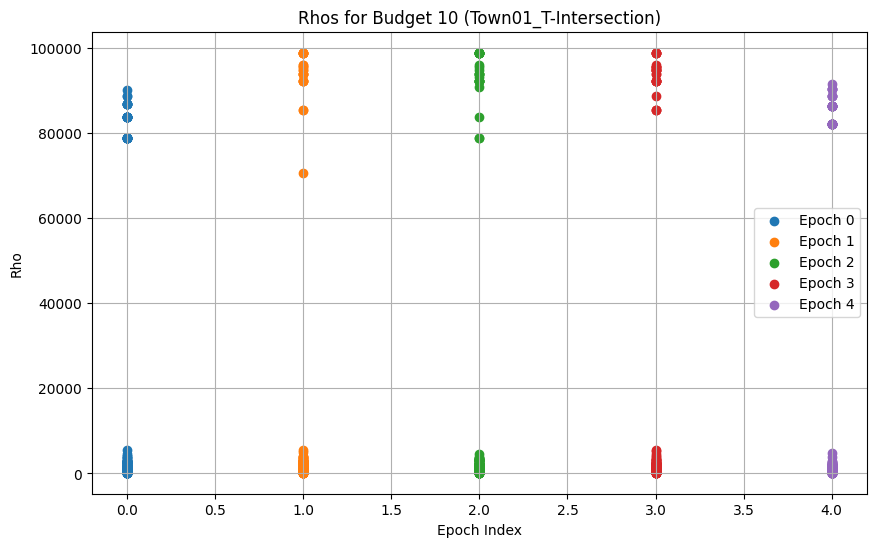

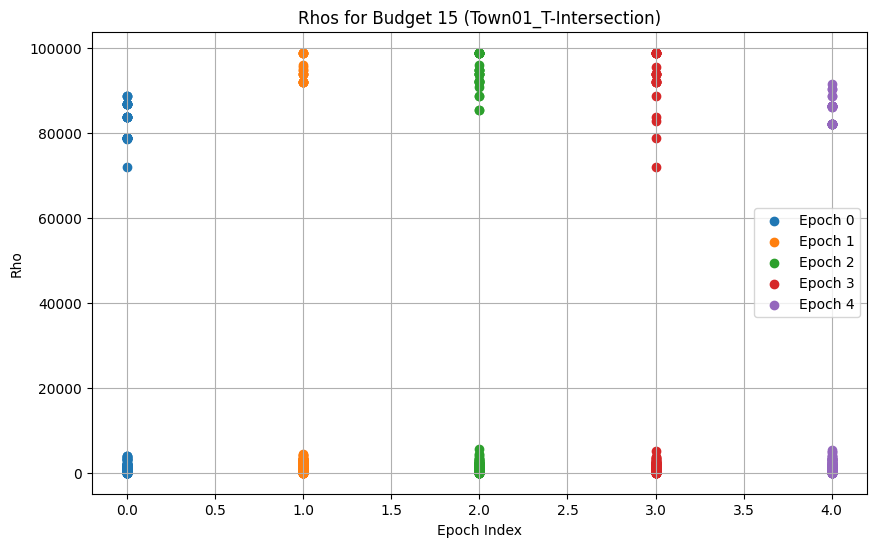

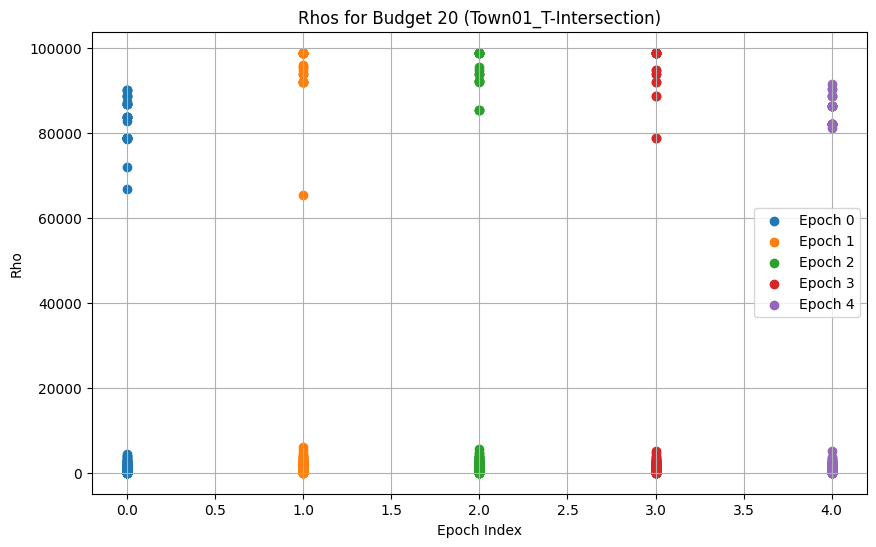

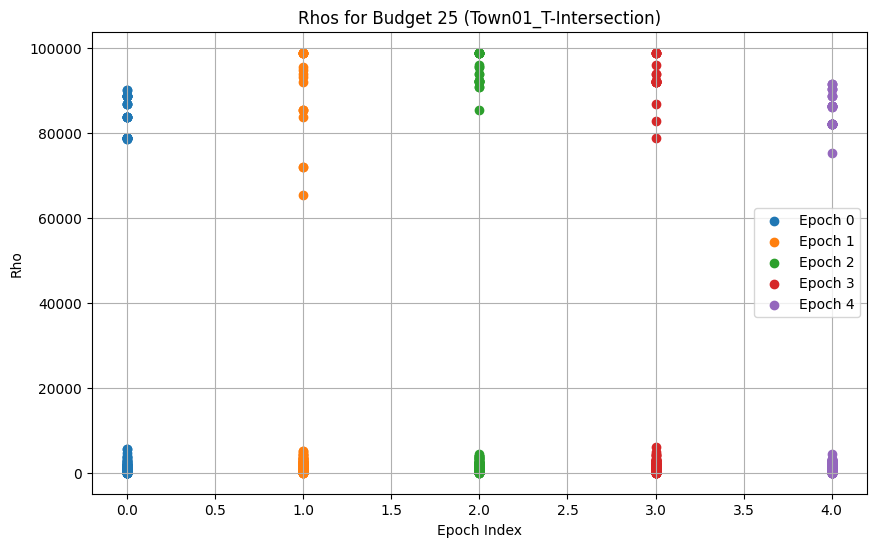

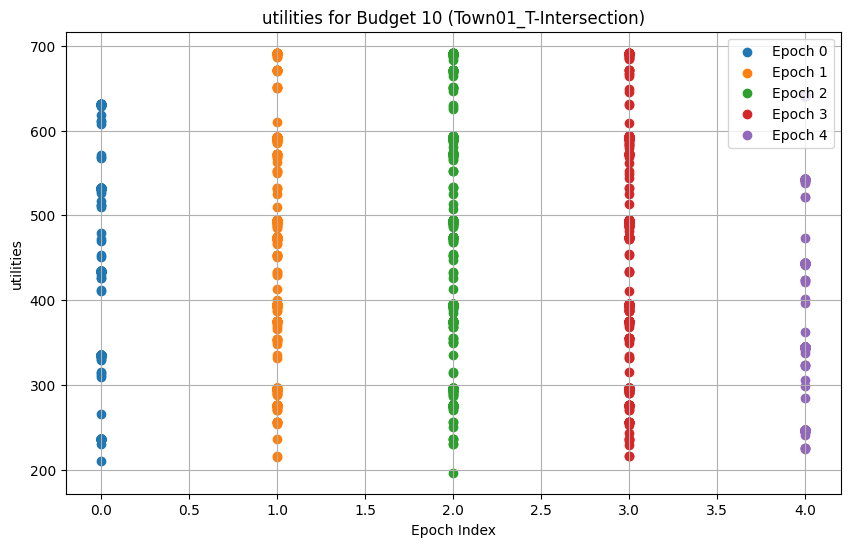

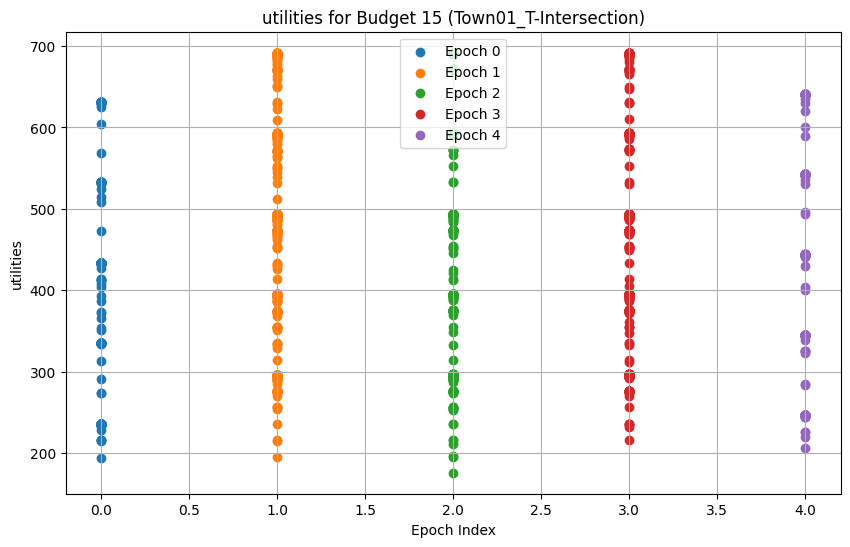

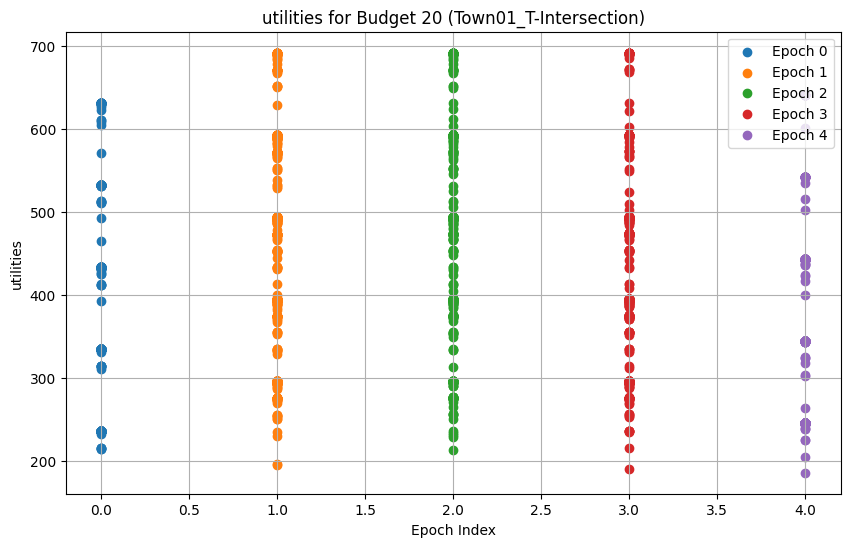

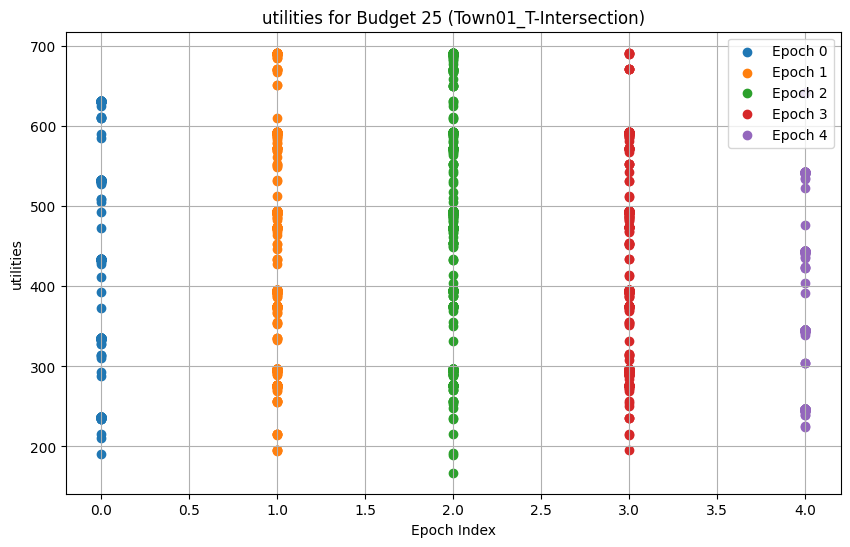

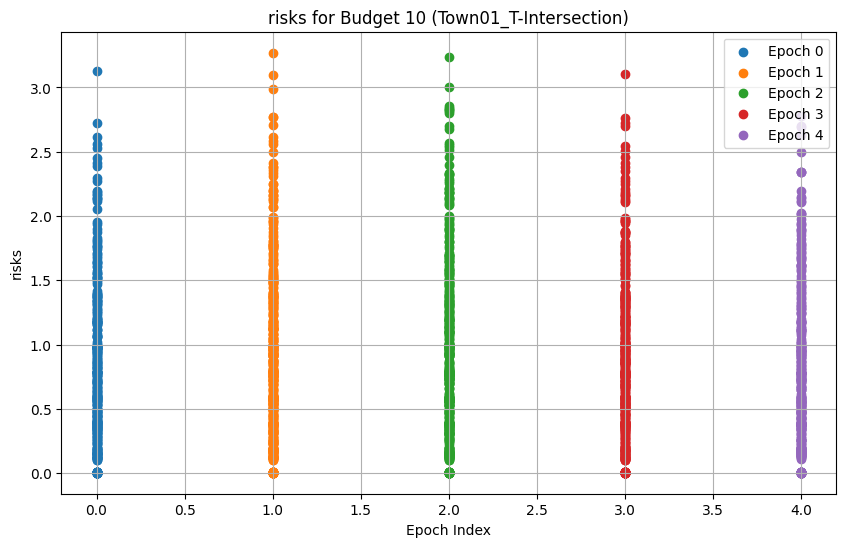

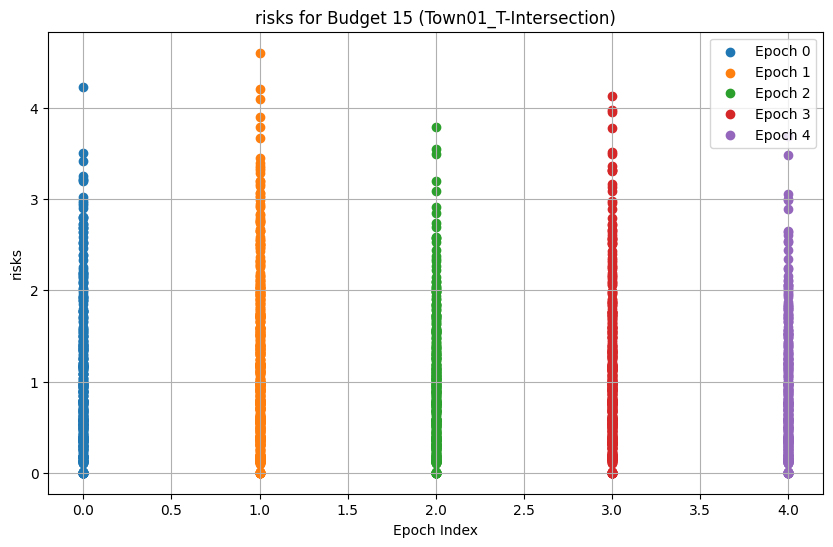

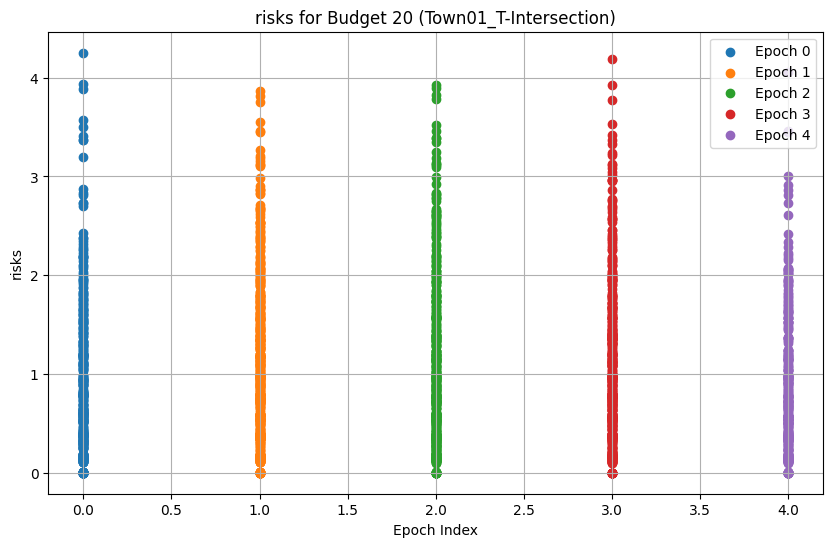

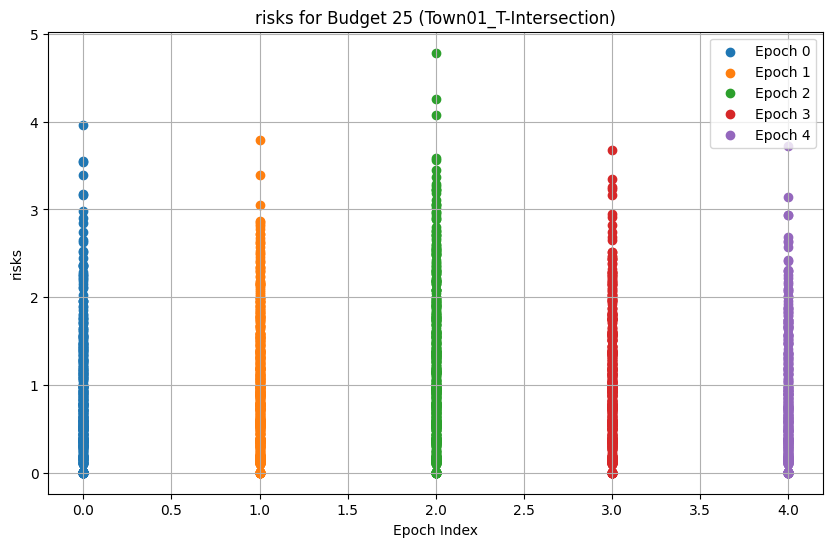

In [4]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Initialize dictionary to store rhos for each budget
rhos_by_budget = {10: {}, 15: {}, 20: {}, 25: {}}
utility_by_budget = {10: {}, 15: {}, 20: {}, 25: {}}
risks_by_budget = {10: {}, 15: {}, 20: {}, 25: {}}
# Iterate over candidate files
counter = 0
for f in cand_files:
    stem = f.stem
    if "Town01_T-Intersection" in stem:
    # if "Town05_Highway3" in stem:
        # Parse budget
        parts = stem.split("_")
        budget = int(parts[3])

        if budget in rhos_by_budget:
            # Load the file and extract rhos
            df = pd.read_csv(f)
            pos = df[df["risk"] > 0]
            if not pos.empty:
                rhos = (pos["utility"] / pos["risk"]).astype(float).tolist()
                epochs = pos["epoch"].tolist()  # Extract epoch values
                utilities = pos["utility"].tolist()
                risks = pos["risk"].tolist()
                # print('maximum utility:',max(utilities))
                # print('minimum utility:',min(utilities))
                for epoch, rho, u, ri in zip(epochs, rhos, utilities, risks):
                    if epoch not in rhos_by_budget[budget]:
                        rhos_by_budget[budget][epoch] = []
                        utility_by_budget[budget][epoch] = []
                        risks_by_budget[budget][epoch] = []
                    if rho >10000:
                        counter += 1
                        print('counter:',counter)
                        # print('rho:',rho)
                        # print('utility:',u)
                        # print('risk:',ri)

                        
                    rhos_by_budget[budget][epoch].append(rho)
                    utility_by_budget[budget][epoch].append (u)
                    risks_by_budget[budget][epoch].append (ri)
                # epoch_index = df["epoch"]  # Extract epoch index from the 'epoch' column
                # rhos_by_budget[budget][epoch_index] = rhos

# Visualization
for budget, epochs in rhos_by_budget.items():
    plt.figure(figsize=(10, 6))
    for epoch, rhos in epochs.items():
        plt.scatter([epoch] * len(rhos), rhos, label=f"Epoch {epoch}")
    plt.title(f"Rhos for Budget {budget} (Town01_T-Intersection)")
    plt.xlabel("Epoch Index")
    plt.ylabel("Rho")
    plt.legend()
    plt.grid(True)
    plt.show()


# Visualization
for budget, epochs in utility_by_budget.items():
    plt.figure(figsize=(10, 6))
    for epoch, utilities in epochs.items():
        plt.scatter([epoch] * len(utilities), utilities, label=f"Epoch {epoch}")
    plt.title(f"utilities for Budget {budget} (Town01_T-Intersection)")
    plt.xlabel("Epoch Index")
    plt.ylabel("utilities")
    plt.legend()
    plt.grid(True)
    plt.show()

# visualization
for budget, epochs in risks_by_budget.items():
    plt.figure(figsize=(10, 6))
    for epoch, risks in epochs.items():
        plt.scatter([epoch] * len(risks), risks, label=f"Epoch {epoch}")
    plt.title(f"risks for Budget {budget} (Town01_T-Intersection)")
    plt.xlabel("Epoch Index")
    plt.ylabel("risks")
    plt.legend()
    plt.grid(True)
    plt.show()

# bulk graphs

In [16]:
parts = f.stem.split("_")
risk_labels = {"low","mid","medium","high","veryhigh","very"}
for idx, tok in enumerate(parts):
    if tok.lower() in risk_labels and idx > 0:
        print(parts[idx])

high


In [1]:
# calculate parameters from offline candidate opt files

from pathlib import Path
import sys
import pandas as pd

# Locate repo root (assumes running somewhere inside the repo)
cwd = Path.cwd().resolve()
REPO_ROOT = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "src" / "motion_planning").exists():
        REPO_ROOT = parent
        break

# Ensure src on path
src_path = REPO_ROOT / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("Repo root:", REPO_ROOT)
print("sys.path[0]:", sys.path[0])

# Prep: locate files and helpers
import pandas as pd
from pathlib import Path

# Reuse REPO_ROOT if defined; otherwise infer
if 'REPO_ROOT' not in globals():
    REPO_ROOT = Path.cwd().resolve()
    for parent in [REPO_ROOT] + list(REPO_ROOT.parents):
        if (parent / 'src' / 'motion_planning').exists():
            REPO_ROOT = parent
            break

SEARCH_BASES = [REPO_ROOT / 'results', REPO_ROOT / 'src/motion_planning/offline_problems/results']

def find_files(pattern: str):
    hits = []
    for base in SEARCH_BASES:
        if base.exists():
            hits.extend(base.rglob(pattern))
    return sorted(set(hits))

risk_labels = {"low","mid","medium","high","veryhigh","very_high","very"}

def parse_scenario_from_stem(stem: str):
    parts = stem.split('_')
    risk_idx = next((i for i,p in enumerate(parts) if p.lower() in risk_labels), None)
    if risk_idx is None or risk_idx < 1:
        return stem
    scen_parts = parts[1:risk_idx-1] if parts[0].lower().startswith('iter') else parts[:risk_idx-1]
    scen = '_'.join(scen_parts) or stem
    return scen

def parse_risk_label_from_stem(stem: str):
    for part in stem.split('_'):
        low = part.lower()
        if low in risk_labels:
            return low
    return "unknown"

# Gather artifacts
cand_files = find_files('*_candidates.csv')
offline_cand_opt = find_files('*_offline_candidates_opt.csv')
offline_edges = find_files('*_edge_values.csv')
offline_timeline = find_files('*_decision_timeline.csv')

print(f"offline candidates: {len(cand_files)} files")
print(f"offline candidates opt: {len(offline_cand_opt)} files")
print(f"edge_values: {len(offline_edges)} files")
print(f"decision_timeline: {len(offline_timeline)} files")


# get the params from all candidate files
from motion_planning.online_algorithms.thresholds import czl_thresholds, bat_threshold
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem

by_key = {}  # (scenario, budget, risk_label) -> {rhos, risks}
for f in offline_cand_opt:
    stem = f.stem.replace("_candidates", "")
    scen = parse_scenario_from_stem(stem)
    risk_label = parse_risk_label_from_stem(stem)
    try:
        df = pd.read_csv(f)
    except Exception as exc:
        print(f"Skip {f.name}: {exc}")
        continue
    if "risk" not in df.columns or "utility" not in df.columns:
        print(f"Skip {f.name}: missing risk/utility")
        continue
    pos = df[df["risk"] > 0]
    if pos.empty:
        print(f"Skip {f.name}: no positive risk")
        continue
    budget = _parse_risk_budget_from_stem(f)
    if budget is None:
        print(f"Skip {f.name}: no budget parsed")
        continue
    rhos = (pos["utility"] / pos["risk"]).astype(float).tolist()
    key = (scen, float(budget), risk_label)
    stats = by_key.setdefault(key, {"rhos": [], "risks": []})
    stats["rhos"].extend(rhos)
    stats["risks"].extend(pos["risk"].astype(float).tolist())

rows = []
for (scen, bud, risk_label), stats in by_key.items():
    if not stats["rhos"] or not stats["risks"]:
        continue
    rows.append(
        {
            "scenario": scen,
            "budget": bud,
            "risk_label": risk_label,
            "rho_min": min(stats["rhos"]),
            "rho_max": max(stats["rhos"]),
            "risk_min": min(r for r in stats["risks"] if r > 0),
        }
    )

param_dir = REPO_ROOT / "results/data/online solutions"
param_dir.mkdir(parents=True, exist_ok=True)
param_path = param_dir / "algorithm_parameters.csv"
PARAMS_BY_SCENARIO = {(r["scenario"], r["budget"], r["risk_label"]): r for r in rows}
if rows:
    out_df = pd.DataFrame(rows).sort_values(["scenario", "budget", "risk_label"])
    out_df.to_csv(param_path, index=False)
    print(f"Saved params -> {param_path} ({len(rows)} scenario/budget/risk_label combos)")
    display(out_df)
else:
    print("No params computed; check offline opt files.")

##


Repo root: /home/abdulrahman/competitive-online-algorithms-motion-planning
sys.path[0]: /home/abdulrahman/competitive-online-algorithms-motion-planning/src
offline candidates: 1600 files
offline candidates opt: 1600 files
edge_values: 1600 files
decision_timeline: 1600 files
Saved params -> /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/algorithm_parameters.csv (80 scenario/budget/risk_label combos)


scenario  budget risk_label     rho_min       rho_max  \
0   Town01_T-Intersection    10.0       high  180.173182   1256.284762   
1   Town01_T-Intersection    10.0        low  215.892111  98873.843440   
2   Town01_T-Intersection    10.0     medium  172.969149  98808.849131   
3   Town01_T-Intersection    10.0       very  169.753900    861.377777   
4   Town01_T-Intersection    15.0       high  121.663489  98898.457921   
..                    ...     ...        ...         ...           ...   
75        Town05_Highway3    20.0       very  222.637681    549.090008   
76        Town05_Highway3    25.0       high  177.540580   1856.190307   
77        Town05_Highway3    25.0        low  251.703297  98358.051431   
78        Town05_Highway3    25.0     medium  189.287688  98358.050875   
79        Town05_Highway3    25.0       very  182.776122    859.516112   

    risk_min  
0   0.196120  
1   0.003000  
2   0.003000  
3   0.331380  
4   0.003000  
..       ...  
75  0.496767  
76  0.158968  
77  0.003000  
78  0.003000  
79  0.317352  

[80 rows x 6 columns]

In [2]:
# percentile-based parameters (rho and risk)
import pandas as pd

if 'by_key' not in globals() or not by_key:
    raise RuntimeError("by_key not defined; run the previous parameter collection cell first.")


def quantiles(series_like):
    s = pd.Series([v for v in series_like if pd.notnull(v)])
    if s.empty:
        return None
    return {
        'min': s.min(),
        'p90': s.quantile(0.90),
        'p95': s.quantile(0.95),
        # lower tail for min_* labels (using 10th/5th percentiles)
        'p10': s.quantile(0.10),
        'p05': s.quantile(0.05),
        'max': s.max(),
    }

pct_rows = []
for (scen, bud, risk_label), stats in by_key.items():
    rho_q = quantiles(stats['rhos'])
    risk_q = quantiles([r for r in stats['risks'] if r > 0])
    if rho_q is None or risk_q is None:
        continue
    pct_rows.append({
        'scenario': scen,
        'budget': bud,
        'risk_label': risk_label,
        'rho_min': rho_q['min'],
        'rho_min_90': rho_q['p10'],
        'rho_min_95': rho_q['p05'],
        'rho_max_90': rho_q['p90'],
        'rho_max_95': rho_q['p95'],
        'rho_max': rho_q['max'],
        'risk_min': risk_q['min'],
        'risk_min_90': risk_q['p10'],
        'risk_min_95': risk_q['p05'],
        'risk_max_90': risk_q['p90'],
        'risk_max_95': risk_q['p95'],
        'risk_max': risk_q['max'],
    })

pct_df = pd.DataFrame(pct_rows).sort_values(['scenario','budget','risk_label'])
display(pct_df)

# Optionally, write alongside the original params
pct_param_path = param_dir / 'algorithm_parameters_percentiles.csv'
pct_df.to_csv(pct_param_path, index=False)
print(f"Saved percentile params -> {pct_param_path} ({len(pct_df)} rows)")


scenario  budget risk_label     rho_min  rho_min_90  \
0   Town01_T-Intersection    10.0       high  180.173182  208.412629   
1   Town01_T-Intersection    10.0        low  215.892111  297.968559   
2   Town01_T-Intersection    10.0     medium  172.969149  222.906756   
3   Town01_T-Intersection    10.0       very  169.753900  199.140079   
4   Town01_T-Intersection    15.0       high  121.663489  160.937778   
..                    ...     ...        ...         ...         ...   
75        Town05_Highway3    20.0       very  222.637681  236.149922   
76        Town05_Highway3    25.0       high  177.540580  193.003747   
77        Town05_Highway3    25.0        low  251.703297  360.945350   
78        Town05_Highway3    25.0     medium  189.287688  218.144559   
79        Town05_Highway3    25.0       very  182.776122  190.272068   

    rho_min_95    rho_max_90    rho_max_95       rho_max  risk_min  \
0   197.260030    468.221373    649.894085   1256.284762  0.196120   
1   272.548744  98799.999996  98800.000391  98873.843440  0.003000   
2   200.905809    745.348664   1234.764013  98808.849131  0.003000   
3   189.365946    358.330596    460.320748    861.377777  0.331380   
4   150.351264    443.945189    649.474129  98898.457921  0.003000   
..         ...           ...           ...           ...       ...   
75  234.222088    306.506611    342.207520    549.090008  0.496767   
76  189.830062    432.846096    592.480908   1856.190307  0.158968   
77  319.245425  97920.415505  98262.344465  98358.051431  0.003000   
78  204.451298    947.001262   1400.289477  98358.050875  0.003000   
79  189.213944    295.099484    338.439636    859.516112  0.317352   

    risk_min_90  risk_min_95  risk_max_90  risk_max_95  risk_max  
0      0.668593     0.528093     2.529565     2.772358  3.094596  
1      0.003000     0.003000     1.388729     1.634819  2.508365  
2      0.424448     0.265959     1.804674     2.060470  3.234567  
3      0.858264     0.593760     2.426334     2.729535  3.125876  
4      0.671687     0.379472     2.684230     2.989036  4.128454  
..          ...          ...          ...          ...       ...  
75     1.485875     1.158551     2.883413     2.900290  2.919913  
76     1.151267     0.846604     3.470447     3.571410  3.633154  
77     0.007000     0.004950     1.702383     1.893464  2.579556  
78     0.551782     0.368458     2.776029     3.065564  3.620608  
79     1.480347     1.181064     3.541898     3.597198  3.645568  

[80 rows x 15 columns]

Saved percentile params -> /home/abdulrahman/competitive-online-algorithms-motion-planning/results/data/online solutions/algorithm_parameters_percentiles.csv (80 rows)


In [3]:
PARAMS_BY_SCENARIO = {(r["scenario"], r["budget"], r["risk_label"]): r for r in pct_rows}
PARAMS_BY_SCENARIO

{('Town01_T-Intersection', 10.0, 'high'): {'scenario': 'Town01_T-Intersection',
  'budget': 10.0,
  'risk_label': 'high',
  'rho_min': 180.17318188181451,
  'rho_min_90': 208.41262927638613,
  'rho_min_95': 197.26002974056183,
  'rho_max_90': 468.2213727190125,
  'rho_max_95': 649.8940854917411,
  'rho_max': 1256.2847618574392,
  'risk_min': 0.1961204282315024,
  'risk_min_90': 0.6685929185711328,
  'risk_min_95': 0.5280926251076723,
  'risk_max_90': 2.5295646760515482,
  'risk_max_95': 2.7723578503809967,
  'risk_max': 3.094595930816769},
 ('Town01_T-Intersection', 10.0, 'low'): {'scenario': 'Town01_T-Intersection',
  'budget': 10.0,
  'risk_label': 'low',
  'rho_min': 215.89211067327375,
  'rho_min_90': 297.96855860017814,
  'rho_min_95': 272.5487444535851,
  'rho_max_90': 98799.99999603914,
  'rho_max_95': 98800.00039126597,
  'rho_max': 98873.84344009135,
  'risk_min': 0.003,
  'risk_min_90': 0.003,
  'risk_min_95': 0.003,
  'risk_max_90': 1.3887291009472276,
  'risk_max_95': 1.634

In [6]:
# run bulk candidates with percentile-based params



from motion_planning.online_algorithms.orb_czl import run_czl_orb
from motion_planning.online_algorithms.orb_bat import run_bat_orb
from motion_planning.online_algorithms.orb_itm import run_itm_online
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem
from motion_planning.constrained_shortest_path.gurobi_license import GUROBI_OPTIONS
from motion_planning.online_algorithms.load_problem_to_solve import load_graph_problem


# Bulk candidates
from motion_planning.utils.paths import ONLINE_RESULTS_CANDIDATES_DIR, ONLINE_RESULTS_GRAPH_DIR
if cand_files:
    for f in cand_files:

        stem = f.stem.replace("_candidates", "")

        scen = parse_scenario_from_stem(stem)
        print("scenario:", scen)
        budget = _parse_risk_budget_from_stem(f)
        
        risk_label = parse_risk_label_from_stem(stem)
        # iteration_index = parse_iteration_index_from_stem(stem)

        params = PARAMS_BY_SCENARIO.get((scen,budget,risk_label), {})
        print(params)
        
        rho_min = params.get('rho_min_90'); rho_max = params.get('rho_max_90'); risk_min = params.get('risk_min_90')

        # print("starting CZL now---------")
        # out_czl = run_czl_orb(f,capacity_override=budget, rho_min=rho_min_avg, rho_max=0.25*rho_max_avg, output_root=ONLINE_RESULTS_CANDIDATES_DIR)
     
        print("starting BAT now---------")
        out_bat = run_bat_orb(f, capacity_override=budget, delta_min=risk_min,rho_min=rho_min, output_root=ONLINE_RESULTS_CANDIDATES_DIR)

        # print(f"[{scen}] CZL -> {out_czl}[{scen}] BAT -> {out_bat}")
        # break
else:
    print('No offline candidate opt files for bulk run.')


scenario: Town01_T-Intersection
{'scenario': 'Town01_T-Intersection', 'budget': 10.0, 'risk_label': 'high', 'rho_min': 180.17318188181451, 'rho_min_90': 208.41262927638613, 'rho_min_95': 197.26002974056183, 'rho_max_90': 468.2213727190125, 'rho_max_95': 649.8940854917411, 'rho_max': 1256.2847618574392, 'risk_min': 0.1961204282315024, 'risk_min_90': 0.6685929185711328, 'risk_min_95': 0.5280926251076723, 'risk_max_90': 2.5295646760515482, 'risk_max_95': 2.7723578503809967, 'risk_max': 3.094595930816769}
starting BAT now---------
Candidate 0: utility=334.06378670844845, risk=0.3607121040390156, rho=926.1230
Threshold psi_t=208.4126, remaining budget=10.0000
Candidate 1: utility=334.3526256188207, risk=0.4826428443308164, rho=692.7537
Threshold psi_t=208.4126, remaining budget=10.0000
Candidate 2: utility=334.7297076129552, risk=0.7120834480910212, rho=470.0709
Threshold psi_t=208.4126, remaining budget=10.0000
Candidate 3: utility=334.98470914962377, risk=1.109534070176284, rho=301.9148
T

NotImplementedError: CZL-ORB requires a feasible candidate at each epoch.

In [10]:
# verify online solution epochs
from pathlib import Path
import pandas as pd

# Expectation: Highway3 scenarios have epochs 0-7; all others 0-4.
if 'REPO_ROOT' not in globals():
    REPO_ROOT = Path.cwd().resolve()
    for parent in [REPO_ROOT] + list(REPO_ROOT.parents):
        if (parent / 'src' / 'motion_planning').exists():
            REPO_ROOT = parent
            break

sol_dir = REPO_ROOT / 'results/data/online solutions/candidates'
if not sol_dir.exists():
    raise FileNotFoundError(f"Solutions directory not found: {sol_dir}")

expected_default = set(range(5))
expected_highway3 = set(range(8))

problems = []
for f in sorted(sol_dir.glob('*.csv')):
    try:
        df = pd.read_csv(f)
    except Exception as exc:
        print(f"Skip {f.name}: {exc}")
        continue
    if 'epoch' not in df.columns:
        print(f"{f.name}: missing 'epoch' column")
        problems.append((f.name, ['missing column'], []))
        continue
    epochs = set(df['epoch'].dropna().astype(int).tolist())
    expected = expected_highway3 if 'highway3' in f.stem.lower() else expected_default
    missing = sorted(expected - epochs)
    extra = sorted(epochs - expected)
    if not missing and not extra:
        print(f"{f.name}: OK ({len(epochs)} epochs)")
    else:
        print(f"{f.name}: missing {missing} extra {extra}")
        problems.append((f.name, missing, extra))

print(f"Checked {len(list(sol_dir.glob('*.csv')))} files; {len(problems)} with issues.")
if problems:
    print("Files with issues:")
    for name, missing, extra in problems:
        print(f"  {name}: missing {missing} extra {extra}")


iter10_Town01_T-Intersection_10_high_5_online_BAT-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_high_5_online_CZL-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_low_5_online_BAT-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_low_5_online_CZL-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_medium_5_online_BAT-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_medium_5_online_CZL-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_very_high_5_online_BAT-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_very_high_5_online_CZL-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_high_5_online_BAT-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_high_5_online_CZL-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_low_5_online_BAT-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_low_5_online_CZL-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_medium_5_online_BAT-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_medium_

In [5]:
len (problems)

14

In [16]:

# Bulk graphs
if offline_edges and offline_timeline:
    timeline_map = {t.stem.replace('_decision_timeline',''): t for t in offline_timeline}
    for edge in offline_edges:
        stem = edge.stem.replace('_edge_values','')
        timeline = timeline_map.get(stem)
        if not timeline:
            print(f'Skip {edge.name}: no matching timeline')
            continue
        scen = parse_scenario_from_stem(stem)
        budget = _parse_risk_budget_from_stem(edge)
        risk_label = parse_risk_label_from_stem(stem)

        params = PARAMS_BY_SCENARIO.get((scen,budget,risk_label), {})
        rho_min = params.get('rho_min_90'); rho_max = params.get('rho_max_90')
        # print(f'rho_min:{rho_min}')
        cap = _parse_risk_budget_from_stem(edge)
        itm_res = run_itm_online(
            edge,
            timeline,
            capacity=cap,
            rho_min_override=rho_min,
            rho_max_override=rho_max,
            gurobi_params=GUROBI_OPTIONS,
            output_root=ONLINE_RESULTS_GRAPH_DIR,
        )
        print(f"[{scen}] ITM epochs: {len(itm_res)} from {edge.name}")
else:
    print('No edge/timeline files for bulk ITM run.')


Solving ITM-ORB epoch from v_0_0 to v_4_6 with Delta_t=10.0, psi_t=76.6707215912679 with epoch_size=4.0, graph_size=21
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commercial use only - registered to ab___@gmail.com
  Setting upper bound for delta: 1.9048
Solving ITM-ORB epoch from v_4_6 to v_11_6 with Delta_t=8.254246124939126, psi_t=105.15130707612892 with epoch_size=7.0, graph_size=21
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commercial use only - registered to ab___@gmail.com
  Setting upper bound for delta: 3.3333
Solving ITM-ORB epoch from v_11_6 to v_14_6 with Delta_t=5.696844194433614, psi_t=167.0247631192716 with epoch_size=3.0, graph_size=21
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commercial use only - registered to ab___@gmail.c

In [9]:
# verify online solution epochs for ITM
from pathlib import Path
import pandas as pd

# Expectation: Highway3 scenarios have epochs 0-7; all others 0-4.
if 'REPO_ROOT' not in globals():
    REPO_ROOT = Path.cwd().resolve()
    for parent in [REPO_ROOT] + list(REPO_ROOT.parents):
        if (parent / 'src' / 'motion_planning').exists():
            REPO_ROOT = parent
            break

sol_dir = REPO_ROOT / 'results/data/online solutions/graph-based'
if not sol_dir.exists():
    raise FileNotFoundError(f"Solutions directory not found: {sol_dir}")

expected_default = set(range(5))
expected_highway3 = set(range(8))

problems = []
for f in sorted(sol_dir.glob('*.csv')):
    try:
        df = pd.read_csv(f)
    except Exception as exc:
        print(f"Skip {f.name}: {exc}")
        continue
    if 'epoch' not in df.columns:
        print(f"{f.name}: missing 'epoch' column")
        problems.append((f.name, ['missing column'], []))
        continue
    epochs = set(df['epoch'].dropna().astype(int).tolist())
    expected = expected_highway3 if 'highway3' in f.stem.lower() else expected_default
    missing = sorted(expected - epochs)
    extra = sorted(epochs - expected)
    if not missing and not extra:
        print(f"{f.name}: OK ({len(epochs)} epochs)")
    else:
        print(f"{f.name}: missing {missing} extra {extra}")
        problems.append((f.name, missing, extra))

print(f"Checked {len(list(sol_dir.glob('*.csv')))} files; {len(problems)} with issues.")
if problems:
    print("Files with issues:")
    for name, missing, extra in problems:
        print(f"  {name}: missing {missing} extra {extra}")


iter10_Town01_T-Intersection_10_high_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_low_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_medium_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_10_very_high_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_high_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_low_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_medium_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_15_very_high_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_20_high_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_20_low_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_20_medium_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_20_very_high_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_25_high_5_online_ITM-ORB.csv: OK (5 epochs)
iter10_Town01_T-Intersection_25_l

In [8]:
# fix bat files with missing epochs

# run bulk candidates with percentile-based params



from motion_planning.online_algorithms.orb_czl import run_czl_orb
from motion_planning.online_algorithms.orb_bat import run_bat_orb
from motion_planning.online_algorithms.orb_itm import run_itm_online
from motion_planning.online_algorithms.orb_itm import _parse_risk_budget_from_stem
from motion_planning.constrained_shortest_path.gurobi_license import GUROBI_OPTIONS
from motion_planning.online_algorithms.load_problem_to_solve import load_graph_problem
stem_for_issued_problems = [f for f,_,_ in problems]
stem_for_issued_problems
issued_parts = [stem.split('_')[0] for stem in stem_for_issued_problems]
issued_parts

# Bulk candidates
from motion_planning.utils.paths import ONLINE_RESULTS_CANDIDATES_DIR, ONLINE_RESULTS_GRAPH_DIR
if cand_files:
    for f in cand_files:

        stem = f.stem.replace("_candidates", "")
        parts = stem.split('_')

        scen = parse_scenario_from_stem(stem)
        # print("scenario:", scen)
        budget = _parse_risk_budget_from_stem(f)
        
        risk_label = parse_risk_label_from_stem(stem)
        # iteration_index = parse_iteration_index_from_stem(stem)
        if parts[0] in issued_parts and scen == 'Town05_Highway3' and budget==10.0 and risk_label=='very':
            params = PARAMS_BY_SCENARIO.get((scen,budget,risk_label), {})
            print(params)
            print(stem)
        
            rho_min = params.get('rho_min_90'); rho_max = params.get('rho_max_90'); risk_min = params.get('risk_min_90')
        
        # print("starting CZL now---------")
        # out_czl = run_czl_orb(f,capacity_override=budget, rho_min=rho_min_avg, rho_max=0.25*rho_max_avg, output_root=ONLINE_RESULTS_CANDIDATES_DIR)
     
            print("starting BAT now---------")
            out_bat = run_bat_orb(f, capacity_override=budget, delta_min=risk_min,rho_min=rho_min*0.5, output_root=ONLINE_RESULTS_CANDIDATES_DIR)

        # print(f"[{scen}] CZL -> {out_czl}[{scen}] BAT -> {out_bat}")
        # break
else:
    print('No offline candidate opt files for bulk run.')


{'scenario': 'Town05_Highway3', 'budget': 10.0, 'risk_label': 'very', 'rho_min': 439.28939219406004, 'rho_min_90': 460.16991056146475, 'rho_min_95': 455.6258093049781, 'rho_max_90': 555.0790982544889, 'rho_max_95': 717.2112385018137, 'rho_max': 1585.8698469201786, 'risk_min': 0.2336466671686449, 'risk_min_90': 0.5415469731360693, 'risk_min_95': 0.4129550251009806, 'risk_max_90': 1.4447510559146577, 'risk_max_95': 1.453799076126164, 'risk_max': 1.4587244108984647}
iter11_Town05_Highway3_10_very_high_8
starting BAT now---------
Candidate 0: utility=467.4486178075093, risk=0.7643548797327033, rho=611.5597
Threshold psi_t=230.0850, remaining budget=10.0000
Candidate 1: utility=468.3486179343962, risk=0.9785404332777884, rho=478.6196
Threshold psi_t=230.0850, remaining budget=10.0000
Selected candidate 0, updated remaining budget: 9.2356
Candidate 0: utility=272.788375991778, risk=0.1138204681595214, rho=2396.6548
Threshold psi_t=249.1271, remaining budget=9.2356
Candidate 1: utility=289.51

['iter11',
 'iter12',
 'iter13',
 'iter15',
 'iter16',
 'iter18',
 'iter19',
 'iter1',
 'iter2',
 'iter3',
 'iter4',
 'iter5',
 'iter6',
 'iter8']

In [ ]:
# fix itm files with missing epochs
# Bulk graphs
from motion_planning.online_algorithms.orb_itm import run_itm_online
from motion_planning.constrained_shortest_path.gurobi_license import GUROBI_OPTIONS
from motion_planning.utils.paths import ONLINE_RESULTS_GRAPH_DIR

if offline_edges and offline_timeline:
    timeline_map = {t.stem.replace('_decision_timeline',''): t for t in offline_timeline}
    for edge in offline_edges:
        stem = edge.stem.replace('_edge_values','')
        timeline = timeline_map.get(stem)
        parts = stem.split('_')
        if not timeline:
            print(f'Skip {edge.name}: no matching timeline')
            continue
        scen = parse_scenario_from_stem(stem)
        
        budget = _parse_risk_budget_from_stem(edge)
        risk_label = parse_risk_label_from_stem(stem)

        params = PARAMS_BY_SCENARIO.get((scen,budget,risk_label), {})
        if parts[0]=='iter8'and scen == 'Town05_Highway1' and budget==10.0 and risk_label=='medium':
            print(stem)
            rho_min = params.get('rho_min_90'); rho_max = params.get('rho_max_90')
            # print(f'rho_min:{rho_min}')
            cap = _parse_risk_budget_from_stem(edge)

            itm_res = run_itm_online(
            edge,
            timeline,
            capacity=cap,
            rho_min_override=rho_min,
            rho_max_override=rho_max,
            gurobi_params=GUROBI_OPTIONS,
            output_root=ONLINE_RESULTS_GRAPH_DIR,
        )
        # rho_min = params.get('rho_min_90'); rho_max = params.get('rho_max_90')
        # # print(f'rho_min:{rho_min}')
        # cap = _parse_risk_budget_from_stem(edge)

        # itm_res = run_itm_online(
        #     edge,
        #     timeline,
        #     capacity=cap,
        #     rho_min_override=rho_min,
        #     rho_max_override=rho_max,
        #     gurobi_params=GUROBI_OPTIONS,
        #     output_root=ONLINE_RESULTS_GRAPH_DIR,
        # )
        # print(f"[{scen}] ITM epochs: {len(itm_res)} from {edge.name}")
# else:
#     print('No edge/timeline files for bulk ITM run.')


iter8_Town05_Highway1_10_medium_5
  Capping rho_max to 10000 to avoid overflow.
Solving ITM-ORB epoch from v_0_0 to v_6_2 with Delta_t=10.0, psi_t=81.26808726630631 with epoch_size=6.0, graph_size=19
  Edges available: 954
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commercial use only - registered to ab___@gmail.com
  Setting upper bound for delta: 3.1579
Solving ITM-ORB epoch from v_6_2 to v_10_2 with Delta_t=6.999271471298002, psi_t=344.42629114709365 with epoch_size=4.0, graph_size=19
  Edges available: 954
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commercial use only - registered to ab___@gmail.com
  Setting upper bound for delta: 2.1053
Solving ITM-ORB epoch from v_10_2 to v_13_2 with Delta_t=6.092542869886158, psi_t=532.8559544061874 with epoch_size=3.0, graph_size=19
  Edges available: 954
Set parameter WLSAccessID